# Configure SBS Parameters

This notebook should be used as a test for ensuring correct SBS image loading and processing before running the SBS module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
from tifffile import imread
import pandas as pd
from snakemake.io import expand
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.sbs.barcode_cycle_utils import compute_barcode_cycle_positions
from lib.sbs.align_cycles import align_cycles
from lib.shared.log_filter import log_filter
from lib.sbs.compute_standard_deviation import compute_standard_deviation
from lib.sbs.max_filter import max_filter
from lib.sbs.find_peaks import find_peaks, find_peaks_spotiflow, plot_channels_with_peaks
from lib.shared.illumination_correction import apply_ic_field, combine_ic_images
from lib.shared.segment_cellpose import prepare_cellpose
from lib.cluster.scrape_benchmarks import get_uniprot_data
from lib.sbs.standardize_barcode_design import standardize_barcode_design, get_barcode_list
from lib.sbs.extract_bases import extract_bases
from lib.sbs.call_reads import call_reads, plot_normalization_comparison
from lib.sbs.call_cells import call_cells
from lib.sbs.call_cells_multi import prep_multi_reads, call_cells_multi
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.sbs.eval_mapping import (
    plot_mapping_vs_threshold,
    plot_cell_mapping_heatmap,
    plot_cell_metric_histogram,
    plot_gene_symbol_histogram,
)

/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_pumori/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing SBS processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels

- `CHANNEL_NAMES`: A list of ordered names for each channel in your SBS image. 
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [3]:
# Define test well and tile
TEST_PLATE = 1
TEST_WELL = "B1"
TEST_TILE = 67
# Derive wildcard dictionary for testing
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# Define image channels with DAPI as the first channel
CHANNEL_NAMES = ["DAPI", "G", "T", "A", "C"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan", "pure_magenta"]

# Remove DAPI channel to get bases
BASES = [channel for channel in CHANNEL_NAMES if channel in ["G", "T", "A", "C"]]
EXTRA_CHANNELS = [channel for channel in CHANNEL_NAMES if channel not in ["G", "T", "A", "C"]]

## <font color='red'>SET PARAMETERS</font>

### Alignment
- `ALIGNMENT_METHOD`: Optional. Method for aligning SBS images between cycles. If not specified, the method will be automatically selected based on available channels, but can be overridden by the user:
    - `DAPI`: the DAPI channel is used for alignment between cycles. Automatically selected if **DAPI is present in each** round of SBS imaging.
    - `sbs_mean`: the mean intensity of base channels is used for alignment between cycles. Automatically selected if **DAPI is not present in each** round of SBS imaging.
- `UPSAMPLE_FACTOR`: Factor used for subpixel alignment. Defaults to `2`
    - Higher values provide more precise alignment but increase processing time.
    - Set to `1` to disable subpixel alignment for faster processing.
- `SKIP_CYCLES`: Optional. List of cycle indices to skip during alignment. Defaults to `None`
    - Use this to exclude problematic cycles that would interfere with alignment
    - Example: `[1]` to skip the first cycle, `[1, 6]` to skip cycles 1 and 6
    - Skipped cycles are completely removed from processing and will not appear in final results
- `MANUAL_BACKGROUND_CYCLE`: Optional. Specific cycle to use as the source for segmentation background channels. Defaults to `None`
    - Use this when you have segmentation channels (e.g., DAPI, GFP) in a specific cycle that you want propagated to all cycles
    - If not specified, automatically selects the cycle with the most extra (non-GTAC) channels
    - Example: `12` to use cycle 12 as the source for background channels
    - Note: This refers to the original cycle index before any cycles are skipped

In [4]:
ALIGNMENT_METHOD = None
UPSAMPLE_FACTOR = 2
SKIP_CYCLES = None
MANUAL_BACKGROUND_CYCLE = None

Loading test images...
Aligning test images...
Final stacked shape before alignment: (12, 5, 2084, 2084)
Method not provided. Using 'DAPI' for alignment based on data structure.
Example aligned image for first cycle:


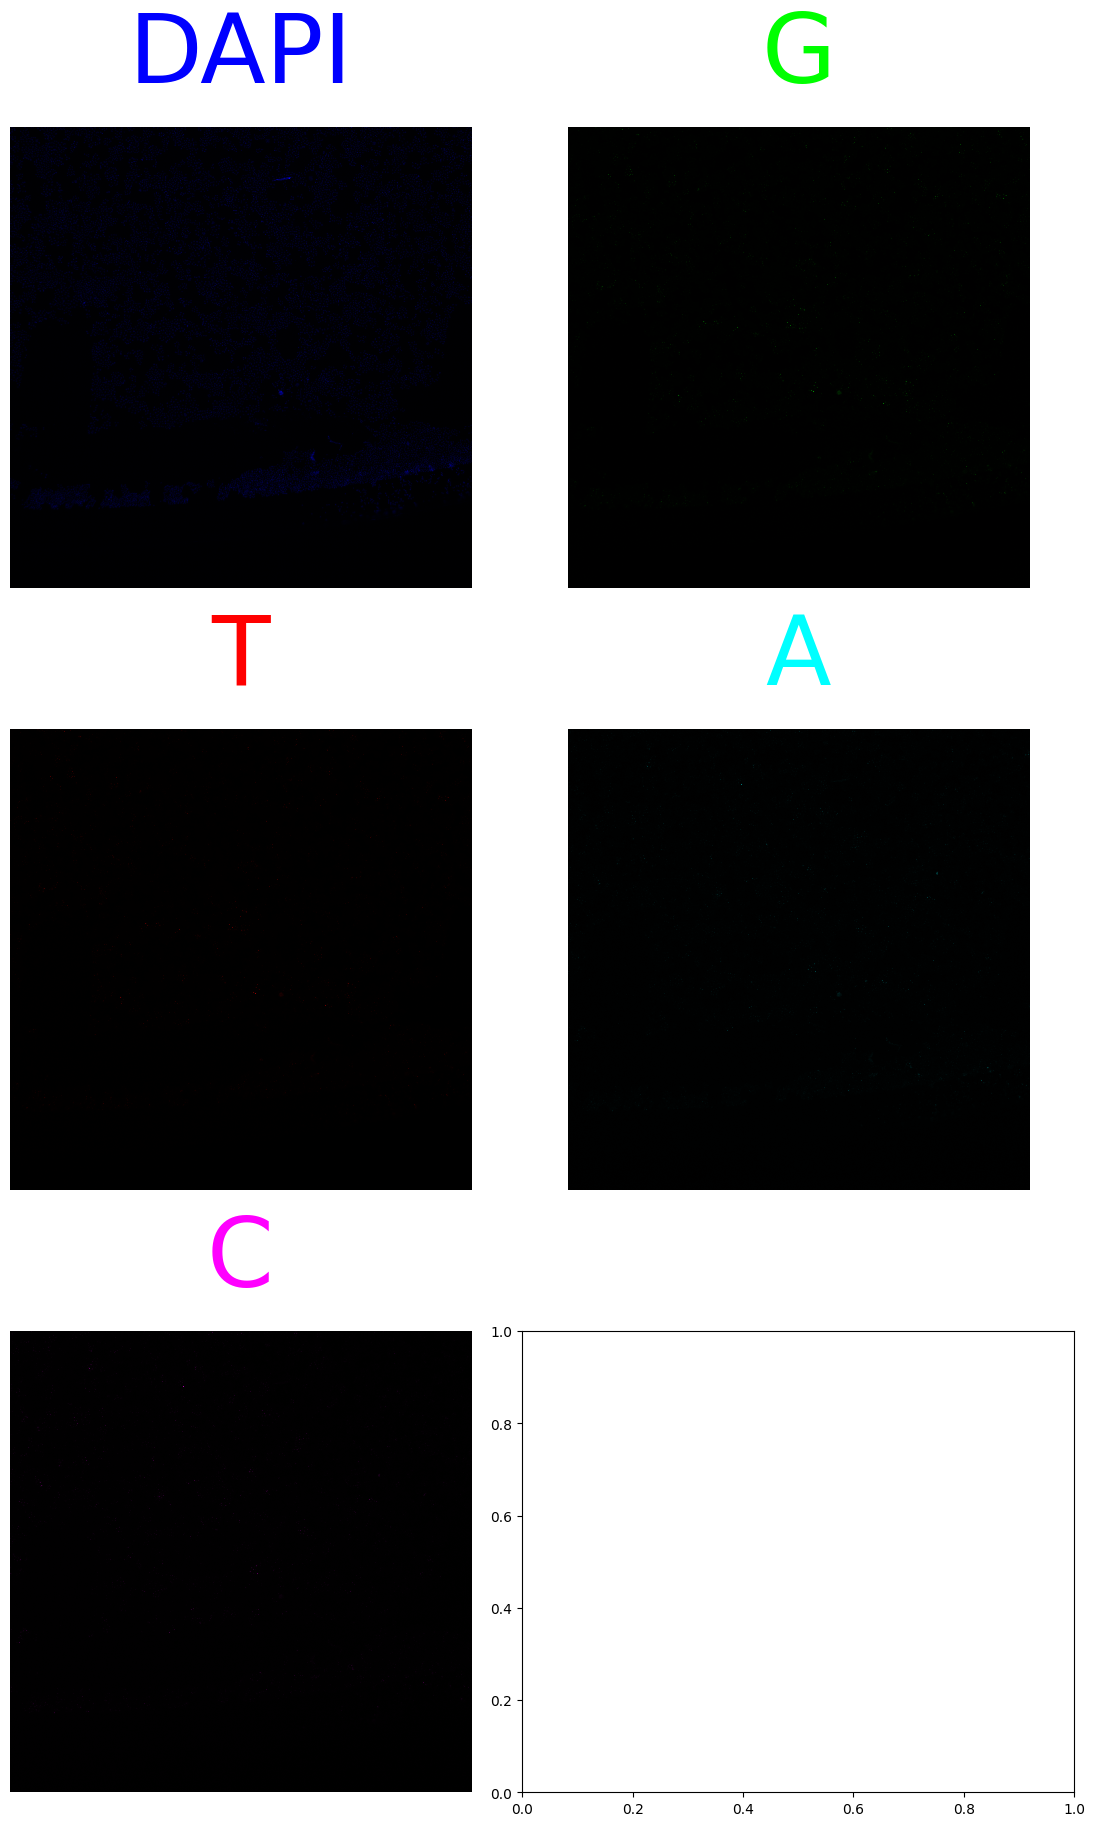

In [5]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = sorted(list(sbs_samples["cycle"].unique()))
# Define cycles for testing if not None
SKIP_CYCLES_INDICES = [SBS_CYCLES.index(c) for c in SKIP_CYCLES] if SKIP_CYCLES is not None else None
MANUAL_BACKGROUND_CYCLE_INDEX = SBS_CYCLES.index(MANUAL_BACKGROUND_CYCLE) if MANUAL_BACKGROUND_CYCLE is not None else None

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
sbs_test_image_paths = expand(
    PREPROCESS_FP
    / "images"
    / "sbs"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
        "image",
        "tiff",
    ),
    cycle=SBS_CYCLES,
)
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]

# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    channel_order=CHANNEL_NAMES,
    method=ALIGNMENT_METHOD,
    upsample_factor=1,
    use_align_within_cycle=False,
    skip_cycles=SKIP_CYCLES_INDICES,
    manual_background_cycle=MANUAL_BACKGROUND_CYCLE_INDEX,
)

# Create and display micropanel of aligned images
print("Example aligned image for first cycle:")
aligned_microimages = [
    Microimage(
        aligned[0, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(aligned.shape[1])
]
aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
plt.show()

# NOTE: You can also loop through all your cycles to display micropanels to be sure of alignment by uncommenting the following lines:
# for cycle_idx in range(aligned.shape[0]):  # Adjust this range if you have a different number of cycles
#     print(f"Example aligned image for cycle {cycle_idx + 1}:")
#     aligned_microimages = [
#         Microimage(
#             aligned[cycle_idx, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
#         )
#         for i in range(aligned.shape[1])
#     ]
#     aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
#     plt.show()

In [6]:
# Save aligned image
from tifffile import imwrite

imwrite("aligned.tiff", aligned)

## <font color='red'>SET PARAMETERS</font>

### Spot detection

- `MAX_FILTER_WIDTH`: Width parameter used for determining the neighborhood size for finding local maxima. No default value, but `3` is suggested
- `SPOT_DETECTION_METHOD`: Methodology for calling spots: 
    - `STANDARD`: Standard method for calling spots, involving Laplacian of Gaussian correction, and computation of spots across cycles. Spots are identified based on signal intensity and consistency across cycles.
        - `PEAK_WIDTH`: Width parameter used for peak detection, sets neighborhood size for finding local maxima of base channels standard deviation. Defaults to `5`
    - `SPOTIFLOW`: Deep learning based methodology for calling spots. Spots are called independently on all 4 bases of a selected cycle, and then coalesced to ensure minimum distance between spots. If this method is selected, the following parameters are required:
        - `SPOTIFLOW_CYCLE_INDEX`: Cycle to use for spot detection
        - `SPOTIFLOW_MODEL`: Model to use for spot detection (e.g., "general", "hybiss")
        - `SPOTIFLOW_THRESHOLD`: Probability threshold for confidence in spot detection
        - `SPOTIFLOW_MIN_DISTANCE`: Minimum distance (in pixels) required between detected spots


In [7]:
# Set parameters:
MAX_FILTER_WIDTH = 2
SPOT_DETECTION_METHOD = "standard"

if SPOT_DETECTION_METHOD == "standard":
   PEAK_WIDTH = 5

elif SPOT_DETECTION_METHOD == "spotiflow":
   SPOTIFLOW_CYCLE_INDEX = 0
   SPOTIFLOW_MODEL = "general"
   SPOTIFLOW_THRESHOLD = 0.5        
   SPOTIFLOW_MIN_DISTANCE = 5

# Derive extra channel indices
EXTRA_CHANNEL_INDICES = [CHANNEL_NAMES.index(channel) for channel in EXTRA_CHANNELS]

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Applying max filter...
Computing standard deviation over cycles...
Finding peaks using standard method...
Example max filtered image for first cycle:


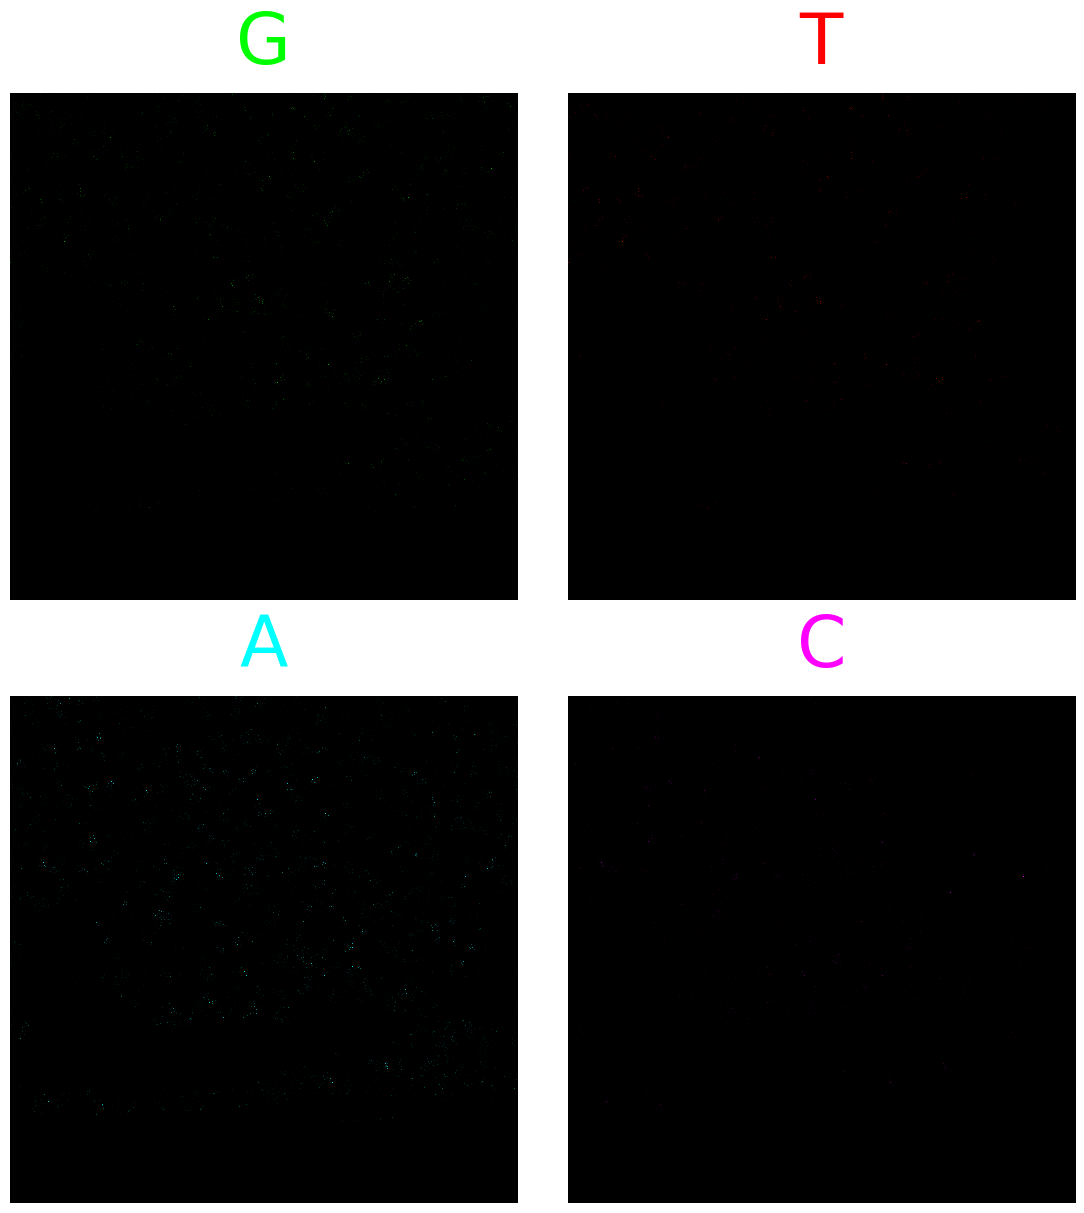

Found 11044 peaks above threshold 200


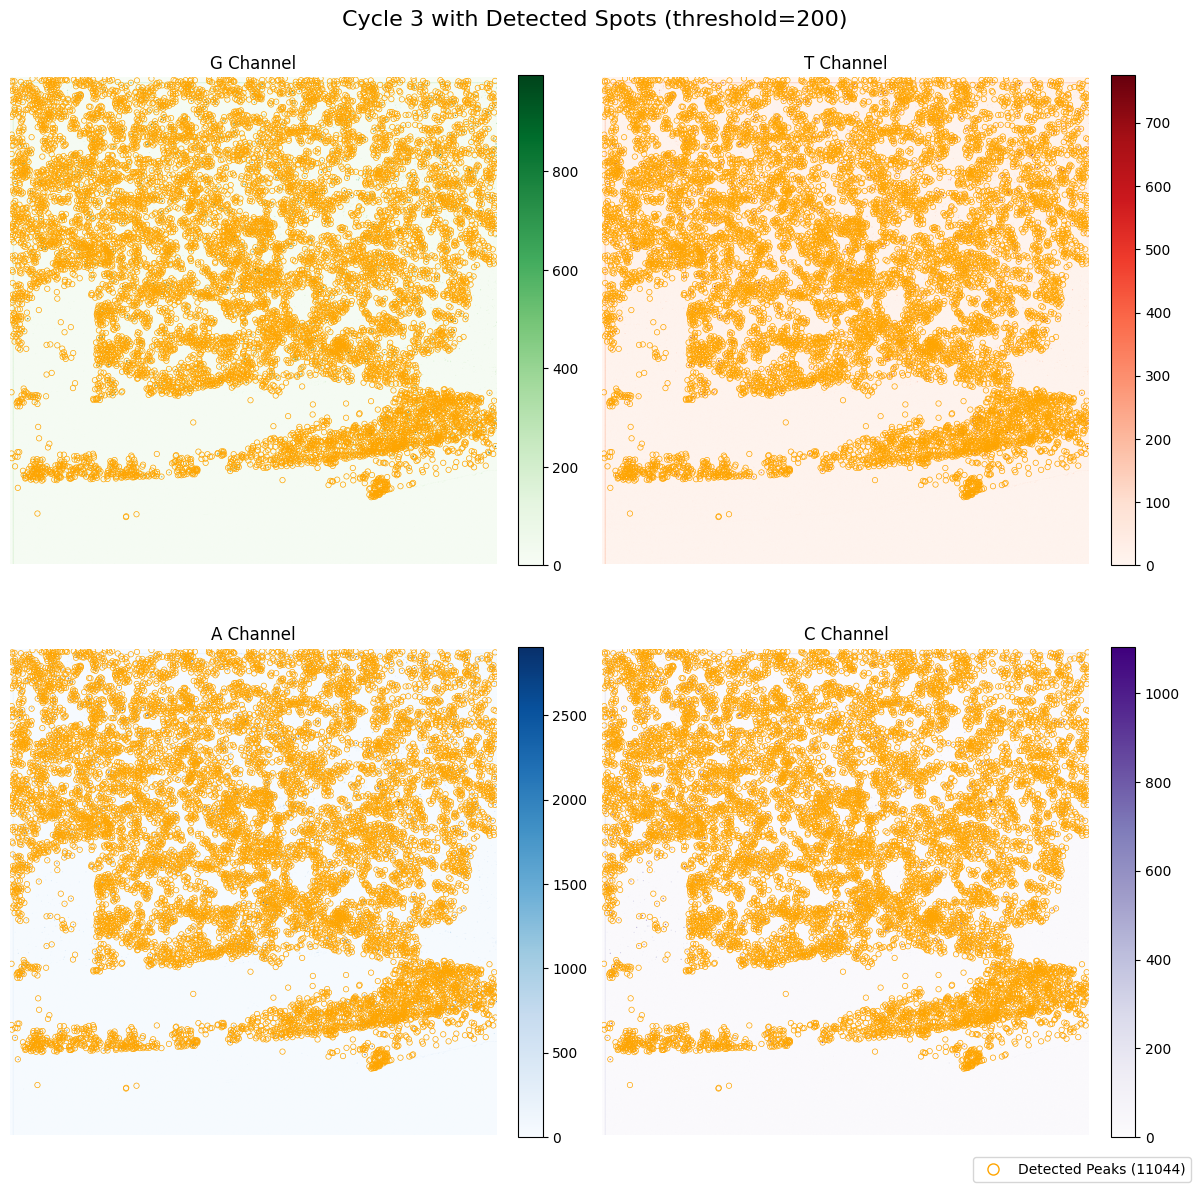

In [8]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=EXTRA_CHANNEL_INDICES)

print("Applying max filter...")
maxed = max_filter(loged, width=MAX_FILTER_WIDTH, remove_index=EXTRA_CHANNEL_INDICES)

if SPOT_DETECTION_METHOD == "standard":
    print("Computing standard deviation over cycles...")
    standard_deviation = compute_standard_deviation(loged, remove_index=EXTRA_CHANNEL_INDICES)
    
    print("Finding peaks using standard method...")
    peaks = find_peaks(standard_deviation, width=PEAK_WIDTH)
    
elif SPOT_DETECTION_METHOD == "spotiflow":
    print(f"Finding peaks using Spotiflow (model: {SPOTIFLOW_MODEL})...")
    peaks, _ = find_peaks_spotiflow(
        aligned_images=aligned, 
        cycle_idx=SPOTIFLOW_CYCLE_INDEX,
        model=SPOTIFLOW_MODEL,
        prob_thresh=SPOTIFLOW_THRESHOLD,
        min_distance=SPOTIFLOW_MIN_DISTANCE,
        remove_index=EXTRA_CHANNEL_INDICES,
        verbose=True
    )

# Create and display micropanel of max filtered datas
print("Example max filtered image for first cycle:")
maxed_microimages = [
    Microimage(maxed[1, i, :, :], channel_names=BASES[i], cmaps=CHANNEL_CMAPS[i + 1])
    for i in range(maxed.shape[1])
]
maxed_panel = create_micropanel(maxed_microimages, add_channel_label=True)
plt.show()

# Plot spots on base channels
fig, axes = plot_channels_with_peaks(
    maxed,                 
    peaks,
    BASES,        
    cycle_number=3,   
    threshold_peaks=200 if SPOT_DETECTION_METHOD == "standard" else None,
    peak_colors=['orange'],
    peak_labels=['Detected Peaks']
)
plt.show()

In [9]:
# import numpy as np

# # Define parameter grid
# max_filter_widths = [2, 3, 4]     # example values
# peak_widths = [3, 5, 7]           # example values
# threshold = 400                   # spot intensity threshold

# results = []

# for mf in max_filter_widths:
#     for pw in peak_widths:
#         print(f"\n=== Running with MAX_FILTER_WIDTH={mf}, PEAK_WIDTH={pw} ===")
        
#         # Apply LoG filter
#         loged = log_filter(aligned, skip_index=EXTRA_CHANNEL_INDICES)

#         # Apply max filter
#         maxed = max_filter(loged, width=mf, remove_index=EXTRA_CHANNEL_INDICES)

#         # Compute standard deviation
#         standard_deviation = compute_standard_deviation(loged, remove_index=EXTRA_CHANNEL_INDICES)

#         # Find peaks (returns an image/array of intensities)
#         peaks = find_peaks(standard_deviation, width=pw)

#         # Count spots above threshold
#         n_spots = np.count_nonzero(peaks >= threshold)

#         print(f"Detected {n_spots} spots >= {threshold}.")

#         results.append({
#             "MAX_FILTER_WIDTH": mf,
#             "PEAK_WIDTH": pw,
#             "spots_detected": n_spots
#         })

# # Sort results by spots_detected, descending
# results_sorted = sorted(results, key=lambda x: x["spots_detected"], reverse=True)

# print("\n=== Summary of grid search ===")
# for r in results_sorted:
#     print(r)


In [10]:
import numpy as np
from tifffile import imwrite

# Analyze the structure of peaks data
print("=== PEAKS DATA STRUCTURE ===")
print(f"Data type: {type(peaks)}")
print(f"Shape: {peaks.shape}")
print(f"Data dtype: {peaks.dtype}")
print(f"Min value: {np.min(peaks)}")
print(f"Max value: {np.max(peaks)}")
print(f"Mean value: {np.mean(peaks):.2f}")
print(f"Standard deviation: {np.std(peaks):.2f}")
print(f"Non-zero elements: {np.count_nonzero(peaks)}")
print(f"Total elements: {peaks.size}")
print(f"Percentage non-zero: {(np.count_nonzero(peaks) / peaks.size) * 100:.2f}%")

# Show value distribution at different thresholds
cutoffs = [50, 75, 100, 125, 150, 175, 200]
print("\n=== VALUE DISTRIBUTION ===")
for cutoff in cutoffs:
    count = np.sum(peaks >= cutoff)
    percentage = (count / peaks.size) * 100
    print(f"Values >= {cutoff}: {count} ({percentage:.2f}%)")

print("\n=== SAVING TIFF FILES ===")

# Save original peaks
imwrite("peaks_original.tiff", peaks)
print(f"Saved: peaks_original.tiff (original data)")

# Save thresholded versions
for cutoff in cutoffs:
    peaks_filtered = np.where(peaks >= cutoff, peaks, 0)
    filename = f"peaks_cutoff_{cutoff}.tiff"
    imwrite(filename, peaks_filtered)
    
    # Report statistics for this cutoff
    non_zero_count = np.count_nonzero(peaks_filtered)
    max_val = np.max(peaks_filtered) if non_zero_count > 0 else 0
    print(f"Saved: {filename}")
    print(f"  - Non-zero pixels: {non_zero_count}")
    print(f"  - Max value retained: {max_val}")
    print(f"  - Values removed: {np.sum(peaks > 0) - non_zero_count}")

print("\n=== COMPLETE ===")
print("All TIFF files have been saved successfully!")

=== PEAKS DATA STRUCTURE ===
Data type: <class 'numpy.ndarray'>
Shape: (2084, 2084)
Data dtype: float64
Min value: 0.0
Max value: 9839.841479752997
Mean value: 2.66
Standard deviation: 58.55
Non-zero elements: 120269
Total elements: 4343056
Percentage non-zero: 2.77%

=== VALUE DISTRIBUTION ===
Values >= 50: 26804 (0.62%)
Values >= 75: 20909 (0.48%)
Values >= 100: 17653 (0.41%)
Values >= 125: 15144 (0.35%)
Values >= 150: 13290 (0.31%)
Values >= 175: 11982 (0.28%)
Values >= 200: 11044 (0.25%)

=== SAVING TIFF FILES ===
Saved: peaks_original.tiff (original data)
Saved: peaks_cutoff_50.tiff
  - Non-zero pixels: 26804
  - Max value retained: 9839.841479752997
  - Values removed: 93465
Saved: peaks_cutoff_75.tiff
  - Non-zero pixels: 20909
  - Max value retained: 9839.841479752997
  - Values removed: 99360


Saved: peaks_cutoff_100.tiff
  - Non-zero pixels: 17653
  - Max value retained: 9839.841479752997
  - Values removed: 102616
Saved: peaks_cutoff_125.tiff
  - Non-zero pixels: 15144
  - Max value retained: 9839.841479752997
  - Values removed: 105125
Saved: peaks_cutoff_150.tiff
  - Non-zero pixels: 13290
  - Max value retained: 9839.841479752997
  - Values removed: 106979
Saved: peaks_cutoff_175.tiff
  - Non-zero pixels: 11982
  - Max value retained: 9839.841479752997
  - Values removed: 108287
Saved: peaks_cutoff_200.tiff
  - Non-zero pixels: 11044
  - Max value retained: 9839.841479752997
  - Values removed: 109225

=== COMPLETE ===
All TIFF files have been saved successfully!


## <font color='red'>SET PARAMETERS</font>

### Illumination Correction and Segmentation

- `DAPI_CYCLE`: Cycle number where DAPI was imaged. Used for illumination correction of the DAPI channel.
- `CYTO_CYCLE`: Cycle number where the cytoplasmic/background channel was imaged. Used for illumination correction of the cytoplasmic channel.
- `CYTO_CHANNEL`: The name of the cytoplasmic channel used for cell boundary detection. 
  - When `DAPI_CYCLE == CYTO_CYCLE`: Can be any channel imaged in that cycle (e.g., "Vimentin", "GFP", "Phalloidin")
  - When `DAPI_CYCLE != CYTO_CYCLE`: Should be a base channel ("G", "T", "A", or "C") since DAPI was imaged separately

**Note**: Only set `DAPI_CYCLE != CYTO_CYCLE` when DAPI was imaged in a separate cycle from your cytoplasmic signal. This typically occurs when using a base channel (G, T, A, C) for cytoplasm detection because no cellular stain was available in the DAPI cycle.

In [11]:
# Define cycle to use for segmentation
DAPI_CYCLE = 1
CYTO_CYCLE = 1
# Define cytoplasmic channel
CYTO_CHANNEL = "G"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)
CYTO_CYCLE_INDEX = SBS_CYCLES.index(CYTO_CYCLE) - len([skip for skip in (SKIP_CYCLES or []) if skip < SBS_CYCLES.index(CYTO_CYCLE)])

# Validate DAPI and CYTO cycles and channels
if DAPI_CYCLE != CYTO_CYCLE and CYTO_CHANNEL not in BASES:
    raise ValueError(
        f"When DAPI_CYCLE ({DAPI_CYCLE}) != CYTO_CYCLE ({CYTO_CYCLE}), "
        f"CYTO_CHANNEL should be a base channel {BASES}, but got '{CYTO_CHANNEL}'. "
        f"If using a cellular stain, set DAPI_CYCLE = CYTO_CYCLE."
    )

Applying illumination correction to segmentation cycle image...
Pre-segmentation images:


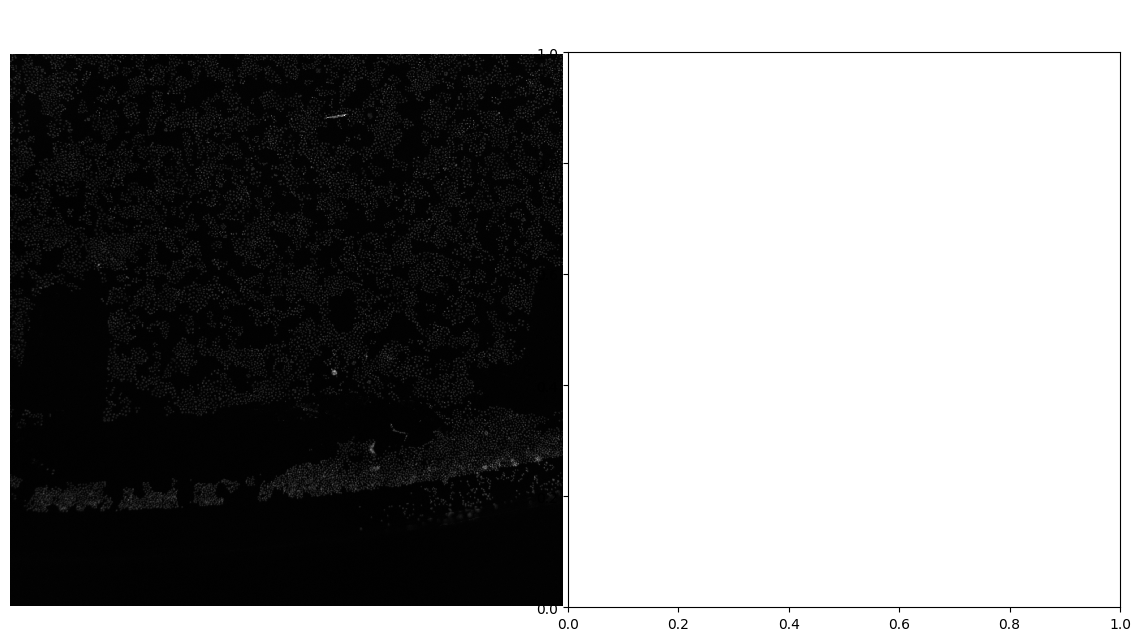

In [12]:
# Determine the cycle to use for segmentation as the cyt
aligned_image_data_segmentation_cycle = aligned[CYTO_CYCLE_INDEX]

print("Applying illumination correction to segmentation cycle image...")

# Logic based on whether DAPI and CYTO come from same or different cycles
if DAPI_CYCLE != CYTO_CYCLE:
    # Different cycles - need to combine IC fields
    ic_field_dapi = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": DAPI_CYCLE}, "ic_field", "tiff")
    )
    ic_field_cyto = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": CYTO_CYCLE}, "ic_field", "tiff")
    )
    # Combine IC fields - need to figure out the right indices for combine_ic_images
    ic_field = combine_ic_images([ic_field_dapi, ic_field_cyto], [EXTRA_CHANNEL_INDICES, None])
else:
    # Same cycle - use one IC field
    ic_field = imread(
        PREPROCESS_FP / "ic_fields" / "sbs" / 
        get_filename({"plate": TEST_PLATE, "well": TEST_WELL, "cycle": DAPI_CYCLE}, "ic_field", "tiff")
    )

# Apply illumination correction field
corrected_image = apply_ic_field(
    aligned_image_data_segmentation_cycle, correction=ic_field
)

# Prepare corrected image for CellPose segmentation
# NOTE: this process is done during the `segment_cellpose`` method below as well
# Use the prepared_cellpose image to test CellPose (see below)
# print("Preparing IC segmentation image for CellPose...")
# cellpose_rgb = prepare_cellpose(
#     corrected_image,
#     DAPI_INDEX,
#     CYTO_INDEX,
# )

# show max filtered data for one round
print("Pre-segmentation images:")
pre_seg_microimages = [
    Microimage(corrected_image[0], channel_names="Dapi"),
]
pre_seg_panel = create_micropanel(pre_seg_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", "stardist", or "watershed" for cell segmentation.

#### Common Parameters
- `GPU`: Set to True to use GPU acceleration (if available).
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing).
- `SEGMENT_CELLS`: Whether to segment cells, or only segment nuclei. If spots are contained in nuclei, there is no need to segment cell bodies. This may speed up analysis.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically, but can be manually overridden.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [17]:
# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

# Common parameters
GPU = False
SEGMENT_CELLS = False
RECONCILE = "contained_in_cells"


if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.3
    NUCLEI_CELLPROB_THRESHOLD = 1
    CELL_FLOW_THRESHOLD = 1 
    CELL_CELLPROB_THRESHOLD = 0 


elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

elif SEGMENTATION_METHOD == "watershed":
    # Parameters for Watershed method
    THRESHOLD_DAPI = 1750 
    THRESHOLD_CELL = 1300
    NUCLEUS_AREA = (10,90)

In [18]:
NUCLEI_DIAMETER = 7
CELL_DIAMETER = 10

Segmenting image with cellpose...


/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_pumori/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)
found 15801 nuclei before removing edges
found 15703 final nuclei


removing edges
Number of nuclei segmented: 15702
Example microplots for DAPI channel and nuclei segmentation:


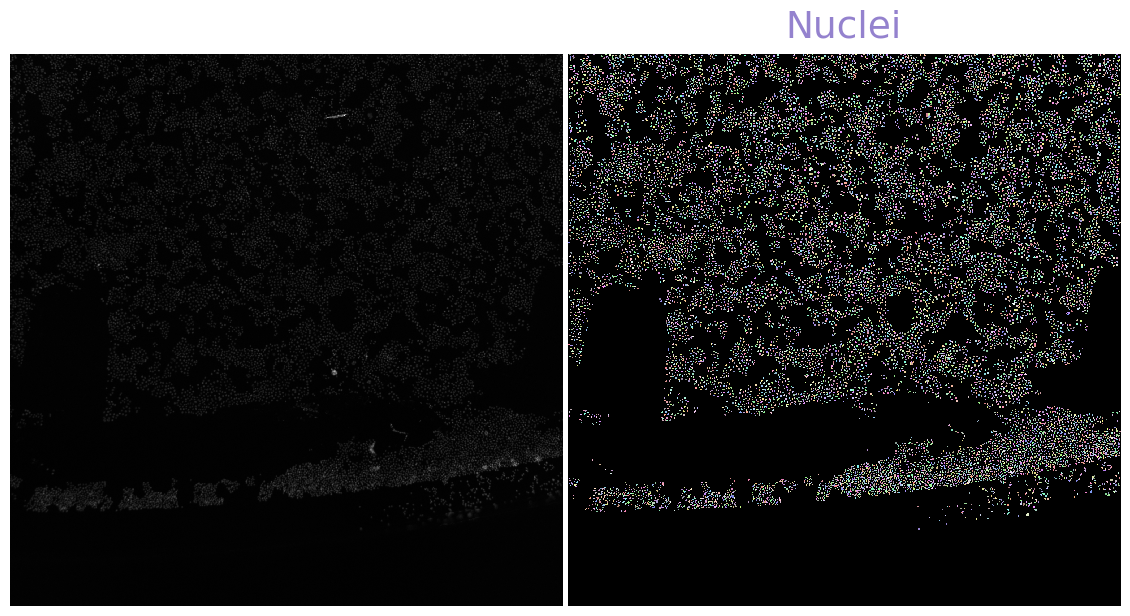

Example microplot for sequencing data annotated with segmentation:


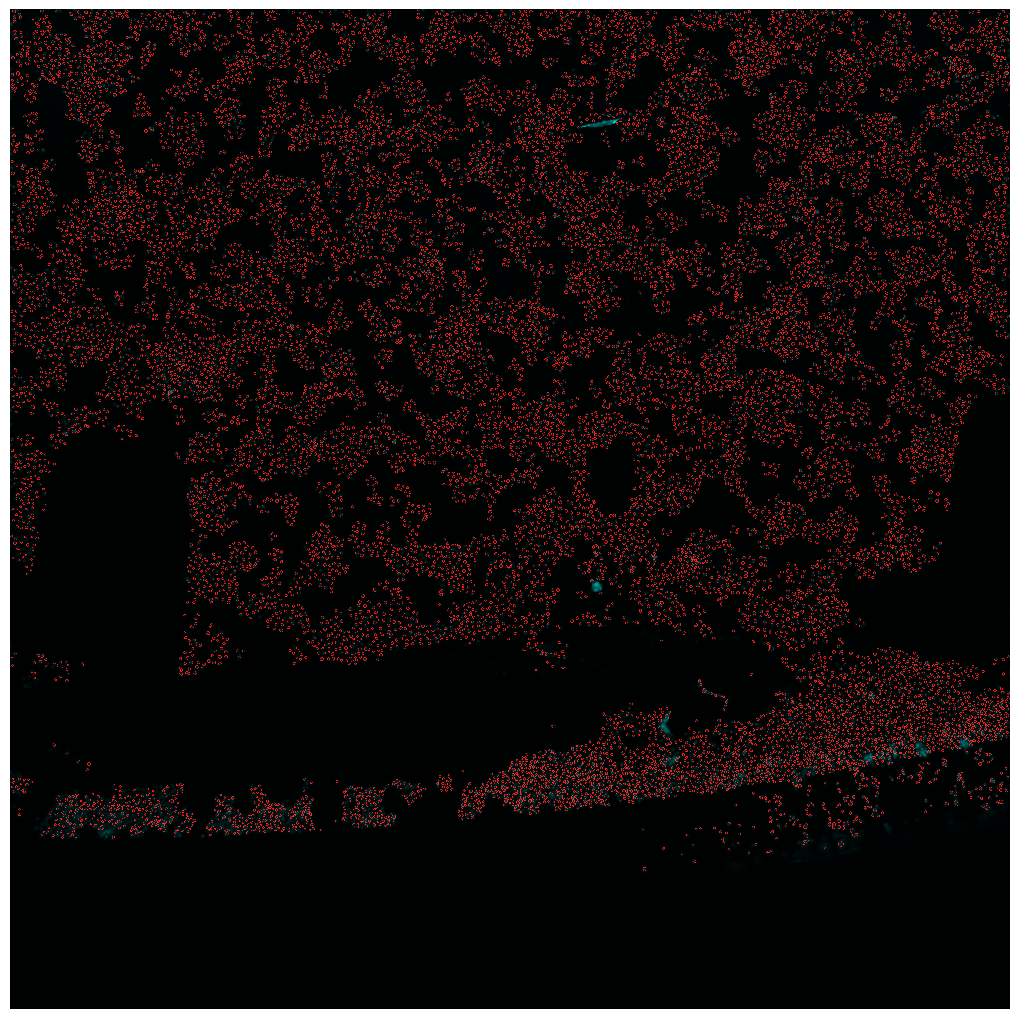

In [20]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=True,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
        cells=SEGMENT_CELLS,
    )

elif SEGMENTATION_METHOD == "watershed":
    from lib.shared.segment_watershed import segment_watershed
    nuclei = segment_watershed(
        corrected_image,
        nuclei_threshold=THRESHOLD_DAPI,
        nuclei_area_min=NUCLEUS_AREA[0],
        nuclei_area_max=NUCLEUS_AREA[1],
        cell_threshold=THRESHOLD_CELL,
        cells=SEGMENT_CELLS,
        # log_transform=LOG_TRANSFORM,
    )

cells = np.zeros_like(nuclei)

# Create and display micropanel of nuclei segmention
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(corrected_image[0], channel_names="Dapi"),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# # Create and display micropanel of segmented cells
# print("Example microplots for merged channels and cells segmentation:")
# cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
# cells_seg_microimages = [
#     Microimage(cellpose_rgb, channel_names="Merged"),
#     Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
# ]
# cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
# plt.show()

# Create and display micropanel of annotated data
print("Example microplot for sequencing data annotated with segmentation:")
annotated_data = image_segmentation_annotations(corrected_image[0], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data,
        channel_names="Merged",
        cmaps=["pure_cyan", "pure_red"],
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

In [21]:
# save the nuclei as a tiff using tiffile
from tifffile import imwrite
imwrite("nuclei.tiff", nuclei.astype(np.uint16))

In [22]:
from tifffile import imwrite
from scipy import ndimage
import numpy as np

# To preserve the original cell labels during dilation:
nuclei = ndimage.grey_dilation(
    nuclei,
    size=(3, 3)  # 3x3 kernel = 1 pixel dilation
)


In [23]:
# save the nuclei as a tiff using tiffile
from tifffile import imwrite
imwrite("nuclei_dilated.tiff", nuclei.astype(np.uint16))

## <font color='red'>SET PARAMETERS</font>

### Barcode Design Table Standardization

Raw barcode design tables from different sources often have inconsistent formatting, column names, and gene annotations. This standardization step transforms your raw design file into a consistent format with validated gene symbols, standardized column names, and proper barcode prefixes. The process includes column renaming, duplicate removal, gene symbol validation (via UniProt), non-targeting control standardization, and barcode prefix generation.

The **most critical parameters** are:  
`PREFIX_MAP`, `PREFIX_RECOMB`, `GENE_SYMBOL_COL`, `GENE_ID_COL`, `MAP_PREFIX_LENGTH`, `RECOMB_PREFIX_LENGTH`, and `SEQUENCING_ORDER`.

### File Paths

- `DF_DESIGN_FP`: Path to raw guide RNA design file.  
- `DF_BARCODE_LIBRARY_FP`: Path to save the cleaned, standardized barcode library.  
- `UNIPROT_DATA_FP`: Temporary path for UniProt annotation data (auto-deleted). Used for gene validation.

### Gene Annotation

- `GENE_SYMBOL_COL`: Column with gene symbols (e.g., `"gene_symbol"`). Set to `None` if not available.  
- `GENE_ID_COL`: Column with gene IDs (e.g., `"gene_id"`). Set to `None` if not available.

### Barcode Columns

- `PREFIX_MAP`: Column name for mapping barcode; renamed to `"prefix_map"`.  
- `PREFIX_RECOMB`: Column name for recombination barcode; renamed to `"prefix_recomb"`.

### Barcode Structure

- `MAP_PREFIX_LENGTH`: Number of sequencing cycles used for mapping barcode.  
- `RECOMB_PREFIX_LENGTH`: Number of sequencing cycles used for recombination barcode.  
- `SKIP_CYCLES_MAP`: List of base positions to skip for mapping (e.g. sequencing cycle 3 for the mapping barcode is out of focus, so we are skipping the nucleotide corresponding to that sequencing cycle). Optional.  
- `SKIP_CYCLES_RECOMB`: List of base positions to skip for recombination. Optional.

### Sequencing Configuration

- `SEQUENCING_ORDER`: Order of barcode sequencing, `"map_recomb"` or `"recomb_map"`.  
- `PREFIX_FUNC`: (Optional) Custom function to generate prefixes from rows. Use for complex barcode layouts.

**Note:**  
You may specify additional options such as filtering functions, prefix generators, and non-targeting control patterns in the `standardize_barcode_design()` call. See the function documentation for examples.


In [24]:
# Define parameters for cleaning up barcode design table
DF_DESIGN_FP = "config/HeLa_combo_library_design.20240624-115737.csv"
DF_BARCODE_LIBRARY_FP = "config/barcode_library.tsv"
UNIPROT_DATA_FP = "config/uniprot_data.tsv"
PREFIX_MAP = "iBAR_2" # This barcode will be renamed to prefix_map
PREFIX_RECOMB = "iBAR_1" # This barcode will be renamed to prefix_recomb
GENE_SYMBOL_COL = "target"
GENE_ID_COL = None
MAP_PREFIX_LENGTH = 12 # Number of cycles sequenced for the mapping barcode
RECOMB_PREFIX_LENGTH = 0 # Number of cycles sequenced for the recombination barcode
SKIP_CYCLES_MAP = None
SKIP_CYCLES_RECOMB = None
SEQUENCING_ORDER = "recomb_map" # or "map_recomb"
NONTARGETING_PATTERNS = ["NONTARGETING_CONTROL", "INTERGENIC_CONTROL"]
NONTARGETING_FORMAT = "nontargeting_{prefix}"
NONTARGETING_PATTERN_MAP = {
    "INTERGENIC_CONTROL": "nontargeting_intergenic_{prefix}",      # Exact match for INTERGENIC_CONTROL
    "NONTARGETING_CONTROL": "nontargeting_noncutting_{prefix}",   # Exact match for NONTARGETING_CONTROL
}

In [25]:
# Get uniprot data and save it temporarily
uniprot_data = get_uniprot_data()
uniprot_data.to_csv(UNIPROT_DATA_FP, sep="\t", index=False)
uniprot_data = pd.read_csv(UNIPROT_DATA_FP, sep="\t")

# Read and standardize guide data
print("Loading and standardizing barcode design table...")
df_design = pd.read_csv(DF_DESIGN_FP)

# Standardize the barcode design table
df_barcode_library = standardize_barcode_design(
    df_design,
    prefix_map=PREFIX_MAP,
    prefix_recomb=PREFIX_RECOMB,
    gene_symbol_col=GENE_SYMBOL_COL,
    gene_id_col=GENE_ID_COL,
    uniprot_data_path=UNIPROT_DATA_FP,
    map_prefix_length=MAP_PREFIX_LENGTH,
    recomb_prefix_length=RECOMB_PREFIX_LENGTH,
    skip_cycles_map=SKIP_CYCLES_MAP,
    skip_cycles_recomb=SKIP_CYCLES_RECOMB, 
    nontargeting_patterns=NONTARGETING_PATTERNS,
    nontargeting_format=NONTARGETING_FORMAT,
    nontargeting_pattern_map=NONTARGETING_PATTERN_MAP,
)
# Delete uniprot data file
# Path(UNIPROT_DATA_FP).unlink(missing_ok=True)

# Save standardized design table
df_barcode_library.to_csv(DF_BARCODE_LIBRARY_FP, sep="\t", index=False)
print(f"Standardized barcode design saved to: {DF_BARCODE_LIBRARY_FP}")
display(df_barcode_library)

# Extract barcodes (prefixes) for mapping
barcodes = get_barcode_list(df_barcode_library, sequencing_order=SEQUENCING_ORDER)
print(f"Extracted {len(barcodes)} barcode prefixes for read mapping")

Fetching UniProt data...
Completed. Total entries: 20460
Loading and standardizing barcode design table...
Standardizing barcode design table with 6000 entries...
Renamed 'iBAR_2' column to 'prefix_map'
Renamed 'iBAR_1' column to 'prefix_recomb'
Renamed 'target' column to 'gene_symbol'
Modified 'prefix_map' using truncation (length=12)
Modified 'prefix_recomb' using truncation (length=0)
Applied pattern 'INTERGENIC_CONTROL' → 'nontargeting_intergenic_{prefix}': 100 controls
Applied pattern 'NONTARGETING_CONTROL' → 'nontargeting_noncutting_{prefix}': 100 controls

Total standardized non-targeting controls: 200
  - INTERGENIC_CONTROL: 100 controls
  - NONTARGETING_CONTROL: 100 controls

Example transformations:
    'NONTARGETING_CONTROL' → 'nontargeting_noncutting_CGCTAAGAATAG'
    'NONTARGETING_CONTROL' → 'nontargeting_noncutting_CGGTAATTTCAC'
    'NONTARGETING_CONTROL' → 'nontargeting_noncutting_CTTCTGATCGTT'
Loaded UniProt data: 20460 entries
Removed 125 entries without gene names
Pro

/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/standardize_barcode_design.py:280: UserWarning: 2269 genes could not be validated against UniProt: ['LOC102724594', 'OR4F16', 'CCNL2_CCNL1', 'GSK3B_GSK3A', 'CNOT8_CNOT7'].... Consider reviewing gene symbols or removing these entries.
  warnings.warn(


prefix_map gene_symbol uniprot_entry prefix_recomb
0     TGCACCTTGCGG       AARS1        P49588              
1     CCAACAAGTTAG       AARS1        P49588              
2     CAGTAAGCCCTC       AARS1        P49588              
3     CTTAATAGTGGG       AARS1        P49588              
4     CGAGGCAGAGGT       ABCB7        O75027              
...            ...         ...           ...           ...
5995  TCGCGCACTATA      OR14J1        Q9UGF5              
5996  CTGCACTAAGCC       OR4D1        Q15615              
5997  TCGAGTTAGGAT       OR2B6        P58173              
5998  CTTAGGTTGACT       OR8B3        Q8NGG8              
5999  TGTGGGCTCTGG       OR6C2        Q9NZP2              

[6000 rows x 4 columns]

Extracted 6000 barcode prefixes for read mapping


## <font color='red'>SET PARAMETERS</font>

### Extract base intensity, call reads, assign to cells
- `THRESHOLD_READS`: Initial threshold for detecting sequencing reads, set to ~50 for preliminary analysis. This parameter will be optimized based on the mapping rate vs. peak threshold plot generated below. A higher threshold increases confidence in read calls but reduces the total number of detected reads.
- `CALL_READS_METHOD`: Method to use for correcting base intensity across channels. The below `plot_normalization_comparison` function will help you assess what method to use. Options are:
    - `MEDIAN`: Uses median-based correction, performed independently for each tile. This is the default method.
    - `PERCENTILE`: Uses percentile-based correction, performed independently for each tile.

In [26]:
# Define parameters for calling reads
THRESHOLD_READS = 0
CALL_READS_METHOD = "percentile"

In [27]:
# Run extract_bases and call_reads with the default threshold
df_bases = extract_bases(
    peaks, maxed, nuclei, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
df_reads = call_reads(df_bases, peaks_data=peaks, method=CALL_READS_METHOD)

/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/extract_bases.py:134: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.stack([CYCLE, CHANNEL])
/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/call_reads.py:333: RuntimeWarning: invalid value encountered in divide
  X_rel = X / rowsums


The following plots will help determine the optimal `THRESHOLD_READS` value for your data:

Mapping rate vs. peak threshold for determining optimal peak cutoff:


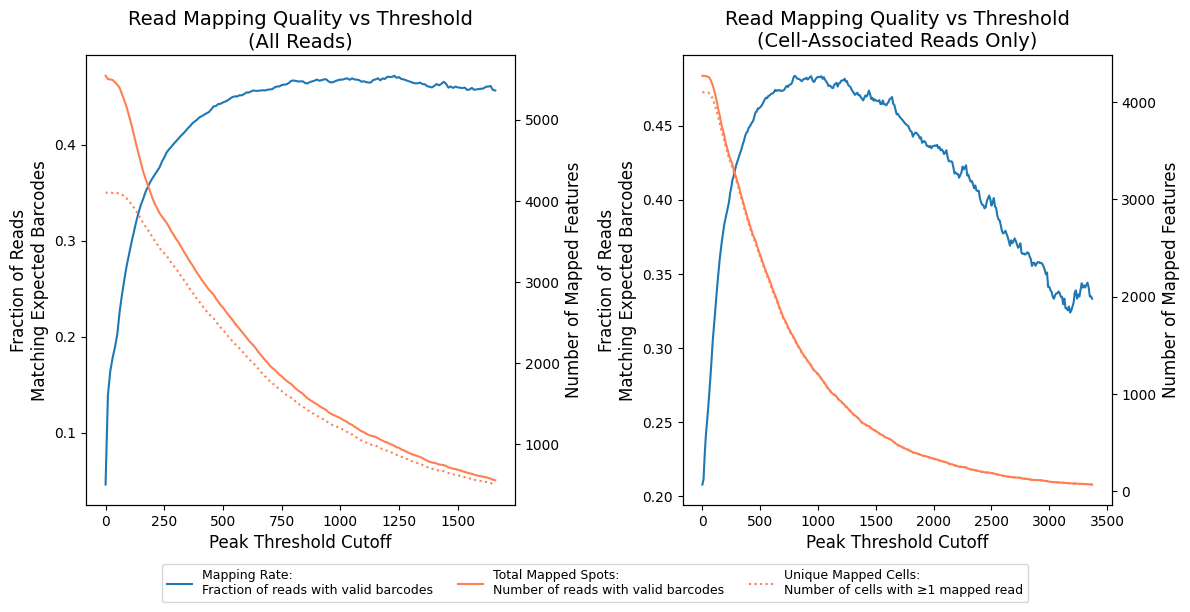

In [28]:
print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

#### Left Plot (All Reads):
- Shows how the peak threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid orange line: Total number of mapped spots (reads with valid barcodes)
- Dotted orange line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Setting Threshold Peaks:
Look for the point where the blue line (mapping rate) begins to plateau (~400)
- Consider the trade-off with number of mapped spots and cells
- A threshold around 300-500 typically provides a good balance:
  - Achieves ~75% mapping rate
  - Retains a reasonable number of mapped spots
  - Maintains coverage across cells

In [29]:
THRESHOLD_READS = 125

Extracted bases:


/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/extract_bases.py:134: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.stack([CYCLE, CHANNEL])


read  cycle channel  intensity   cell     i     j  tile well
288         6      1       G        105      0     6   319    67   B1
289         6      1       T         57      0     6   319    67   B1
290         6      1       A       1484      0     6   319    67   B1
291         6      1       C        575      0     6   319    67   B1
292         6      2       G         68      0     6   319    67   B1
...       ...    ...     ...        ...    ...   ...   ...   ...  ...
726283  15130     11       C         26  15800  1793  1325    67   B1
726284  15130     12       G         37  15800  1793  1325    67   B1
726285  15130     12       T          4  15800  1793  1325    67   B1
726286  15130     12       A          8  15800  1793  1325    67   B1
726287  15130     12       C         22  15800  1793  1325    67   B1

[726912 rows x 9 columns]

Base intensity across cycles:


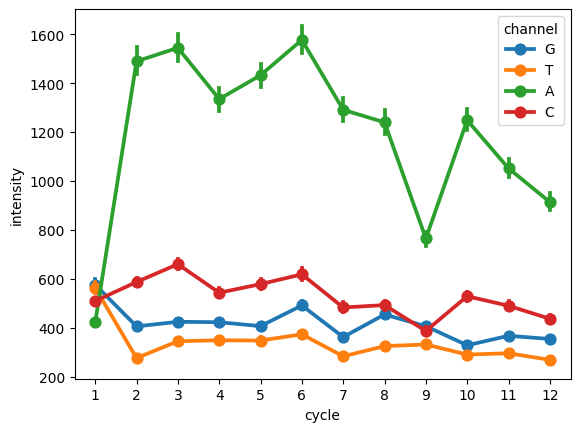

Intensity for each base:


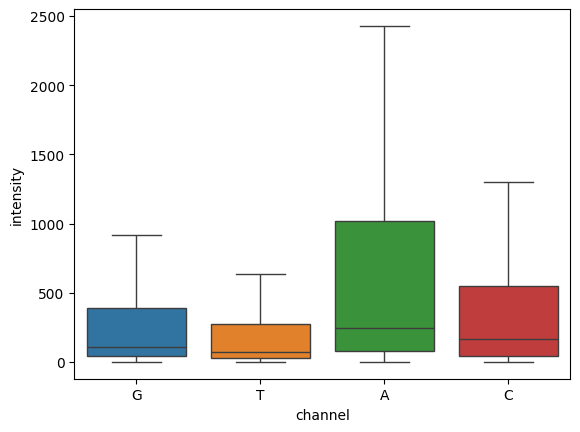

Different normalization methods


/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/call_reads.py:333: RuntimeWarning: invalid value encountered in divide
  X_rel = X / rowsums
/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/call_reads.py:333: RuntimeWarning: invalid value encountered in divide
  X_rel = X / rowsums


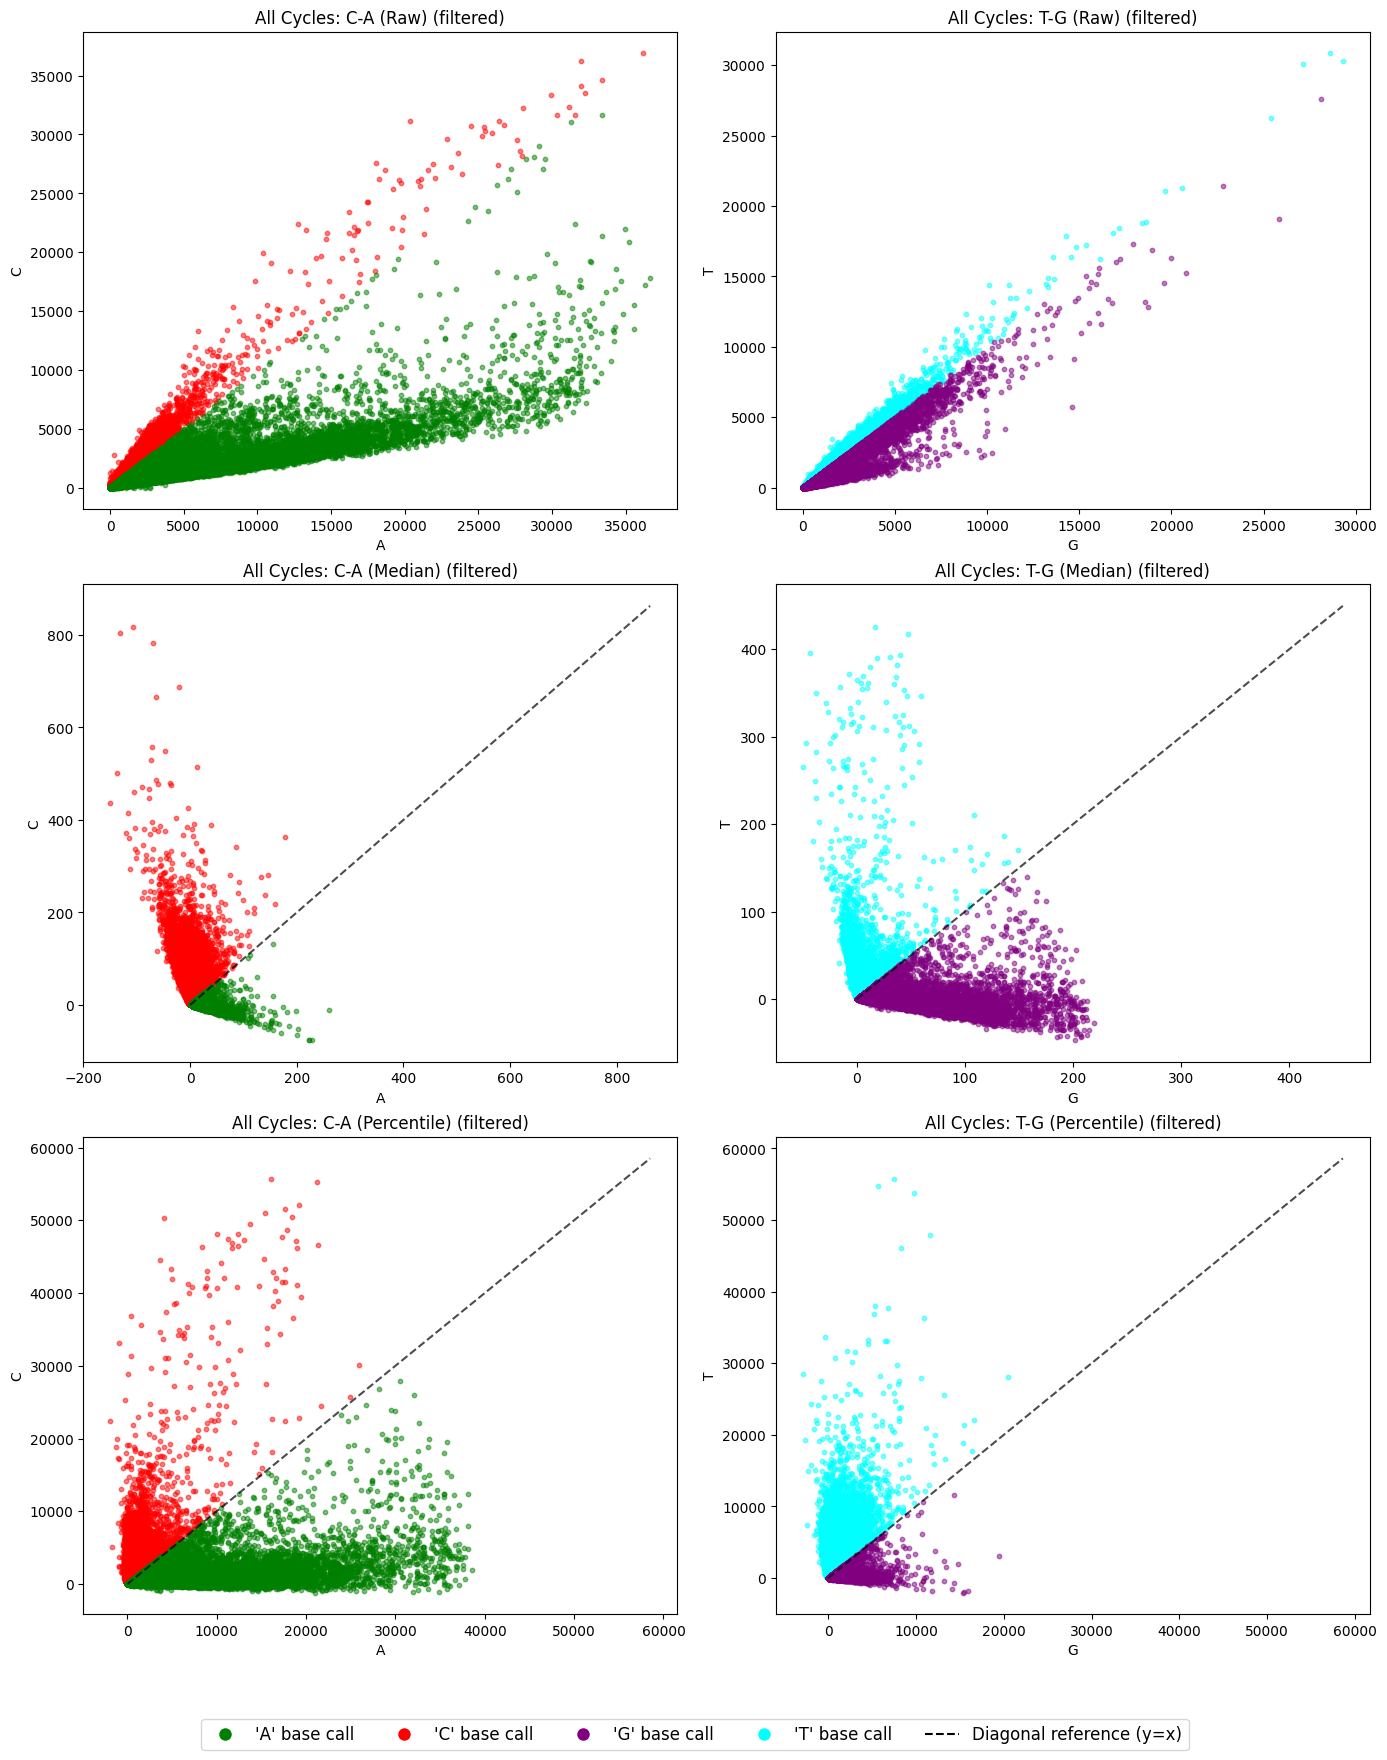

In [30]:
# Re-run extract_bases and call_reads with the new threshold
print("Extracted bases:")
df_bases = extract_bases(
    peaks, maxed, nuclei, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(
    x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False
)
plt.show()

print("Different normalization methods")
plot_normalization_comparison(df_bases, base_order = BASES)

In [31]:
print("Called reads:")
df_reads = call_reads(df_bases, peaks_data=peaks)
display(df_reads)

Called reads:


read   cell     i     j  tile well       barcode       Q_0       Q_1  \
290         6      0     6   319    67   B1  ACAACAAAAAAA  0.738140  0.054758   
914        19      0     8   291    67   B1  CAAACAAAAAAA  1.000000  1.000000   
1058       22      0     8   904    67   B1  CGAACAAAAAAA  1.000000  1.000000   
1538       32      0    10   355    67   B1  CAAACAAAATAA  1.000000  1.000000   
2498       52      0    11  1644    67   B1  CTAAGAAAAGAA  1.000000  0.138195   
...       ...    ...   ...   ...   ...  ...           ...       ...       ...   
723218  15067  15794  1746  1363    67   B1  TAAAAAAAAAAA  0.811368  1.000000   
723842  15080  15796  1754  1579    67   B1  AAAAAAAACCCC  0.000000  0.000000   
724034  15084  15797  1759  1542    67   B1  AAAAAAATCCCC  0.000000  0.000000   
724130  15086  15798  1761  1401    67   B1  TAAAAAAAAAAA  0.633979  0.000000   
726242  15130  15800  1793  1325    67   B1  CAAAAAAAAAAA  1.000000  0.000000   

        Q_2  ...       Q_4  Q_5  Q_6      Q_7       Q_8       Q_9      Q_10  \
290     0.0  ...  0.124275  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
914     0.0  ...  1.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
1058    0.0  ...  0.231544  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
1538    0.0  ...  1.000000  0.0  0.0  0.00000  0.000000  1.000000  0.000000   
2498    0.0  ...  0.666667  0.0  0.0  0.00000  0.000000  0.295781  0.000000   
...     ...  ...       ...  ...  ...      ...       ...       ...       ...   
723218  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
723842  0.0  ...  0.000000  0.0  0.0  0.00000  0.738140  1.000000  1.000000   
724034  0.0  ...  0.000000  0.0  0.0  0.73814  0.815071  0.739939  0.777561   
724130  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
726242  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   

            Q_11  Q_min         peak  
290     0.000000    0.0   670.205527  
914     0.000000    0.0   758.406273  
1058    0.000000    0.0   253.629187  
1538    0.000000    0.0   738.152462  
2498    0.000000    0.0   553.860014  
...          ...    ...          ...  
723218  0.000000    0.0   310.164270  
723842  1.000000    0.0   159.058194  
724034  0.678504    0.0  3309.542442  
724130  0.000000    0.0   132.563798  
726242  0.000000    0.0   134.805902  

[15144 rows x 21 columns]

## <font color='red'>SET PARAMETERS</font>

### Read mapping
### Automatically generated:
- `MAP_START`, `MAP_END`: Start and end positions (1-based, inclusive) for the mapping barcode prefix within the full barcode sequence.
- `RECOMB_START`, `RECOMB_END`: Start and end positions (1-based, inclusive) for the recombination barcode prefix within the full barcode sequence.
- `MAP_COL`: Column name in the reads dataframe containing the mapping barcode prefix (e.g., `'prefix_map'`).
- `RECOMB_COL`: Column name in the reads dataframe containing the recombination barcode prefix (e.g., `'prefix_recomb'`).
- `RECOMB_FILTER_COL`: Column name for recombination barcode quality score (e.g., `'Q_recomb'`).
### User-determined
- `Q_MIN`: The minimum quality score for each base read. Calculated as 1 - [log2(2 + second) / log2(2 + first)]. Default is 0 and typically remains unchanged. While the Q_min plot above shows the relationship between Q_min and mapping rate, adjusting THRESHOLD_READS is the preferred method for quality control. Higher Q_min values are more stringent but can excessively filter valid reads.
- `ERROR_CORRECT`: Whether to perform error correction on barcode mapping. If `True`, further parameters such as `MAX_DISTANCE` and `DISTANCE_METRIC` can be defined..
- `RECOMB_Q_THRESHOLD`: Minimum quality threshold for the recombination barcode.
- `BARCODE_INFO_COLS`: List of columns from the barcode library to include in the output (e.g., `['gene_symbol']`).
- `MAX_DISTANCE`: Maximum allowed distance for error correction (e.g., Hamming distance).
- `SORT_CALLS`: Method for prioritizing barcodes in each cell. Use `'count'` if multiple barcodes are expected per cell (e.g. using an mRNA identifier protocol) - prioritizes by read frequency. Use `'peak'` if one barcode per perturbation is expected per cell (e.g. using a DNA identifier protocol) - prioritizes by signal intensity. Default is `'count'`.

The following plots will help determine the optimal `Q_MIN` value for your data:

Mapping rate vs. Q_min for determining optimal sequence quality cutoff:


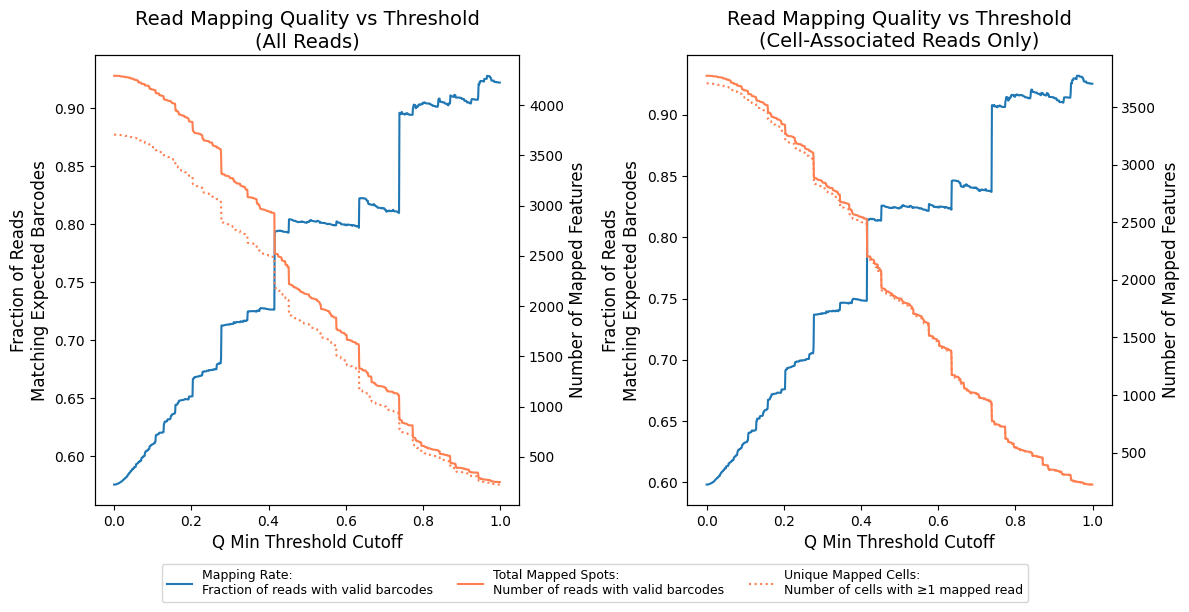

In [32]:
print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

In [33]:
display(df_reads)

read   cell     i     j  tile well       barcode       Q_0       Q_1  \
290         6      0     6   319    67   B1  ACAACAAAAAAA  0.738140  0.054758   
914        19      0     8   291    67   B1  CAAACAAAAAAA  1.000000  1.000000   
1058       22      0     8   904    67   B1  CGAACAAAAAAA  1.000000  1.000000   
1538       32      0    10   355    67   B1  CAAACAAAATAA  1.000000  1.000000   
2498       52      0    11  1644    67   B1  CTAAGAAAAGAA  1.000000  0.138195   
...       ...    ...   ...   ...   ...  ...           ...       ...       ...   
723218  15067  15794  1746  1363    67   B1  TAAAAAAAAAAA  0.811368  1.000000   
723842  15080  15796  1754  1579    67   B1  AAAAAAAACCCC  0.000000  0.000000   
724034  15084  15797  1759  1542    67   B1  AAAAAAATCCCC  0.000000  0.000000   
724130  15086  15798  1761  1401    67   B1  TAAAAAAAAAAA  0.633979  0.000000   
726242  15130  15800  1793  1325    67   B1  CAAAAAAAAAAA  1.000000  0.000000   

        Q_2  ...       Q_4  Q_5  Q_6      Q_7       Q_8       Q_9      Q_10  \
290     0.0  ...  0.124275  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
914     0.0  ...  1.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
1058    0.0  ...  0.231544  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
1538    0.0  ...  1.000000  0.0  0.0  0.00000  0.000000  1.000000  0.000000   
2498    0.0  ...  0.666667  0.0  0.0  0.00000  0.000000  0.295781  0.000000   
...     ...  ...       ...  ...  ...      ...       ...       ...       ...   
723218  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
723842  0.0  ...  0.000000  0.0  0.0  0.00000  0.738140  1.000000  1.000000   
724034  0.0  ...  0.000000  0.0  0.0  0.73814  0.815071  0.739939  0.777561   
724130  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   
726242  0.0  ...  0.000000  0.0  0.0  0.00000  0.000000  0.000000  0.000000   

            Q_11  Q_min         peak  
290     0.000000    0.0   670.205527  
914     0.000000    0.0   758.406273  
1058    0.000000    0.0   253.629187  
1538    0.000000    0.0   738.152462  
2498    0.000000    0.0   553.860014  
...          ...    ...          ...  
723218  0.000000    0.0   310.164270  
723842  1.000000    0.0   159.058194  
724034  0.678504    0.0  3309.542442  
724130  0.000000    0.0   132.563798  
726242  0.000000    0.0   134.805902  

[15144 rows x 21 columns]

In [34]:
print("Number of reads in cells:")
df_reads[df_reads["cell"] > 0].shape[0]

Number of reads in cells:


11815

In [35]:
print("Number of reads outside cells:")
df_reads[df_reads["cell"] == 0].shape[0]

Number of reads outside cells:


3329

In [36]:
from lib.sbs.eval_mapping import plot_read_mapping_heatmap

reads_no_cell = df_reads[df_reads["cell"] == 0]
print("Reads not mapped to cells:")
plot_read_mapping_heatmap(reads_no_cell, barcodes, return_plot=False, return_summary=True)

Reads not mapped to cells:


/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/eval_mapping.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reads.loc[:, "mapped"] = df_reads["barcode"].isin(barcodes)


well  tile  fraction of reads mapping
1   B1    67                   0.196155

In [37]:
print("Reads mapped to cells:")
reads_cell = df_reads[df_reads["cell"] != 0]
plot_read_mapping_heatmap(reads_cell, barcodes, return_plot=False, return_summary=True)

Reads mapped to cells:


/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/eval_mapping.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reads.loc[:, "mapped"] = df_reads["barcode"].isin(barcodes)


well  tile  fraction of reads mapping
1   B1    67                   0.384765

In [38]:
print("All reads:")
plot_read_mapping_heatmap(df_reads, barcodes, return_plot=False, return_summary=True)

All reads:


well  tile  fraction of reads mapping
1   B1    67                   0.343304

#### Left Plot (All Reads):
- Shows how Q_min threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid red line: Total number of mapped spots (reads with valid barcodes)
- Dotted red line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Interpreting Q_min Results:
With our optimized peak threshold, these plots confirm that adjusting Q_min provides little benefit:
- The mapping rate (blue line) is already very high at Q_min = 0
- Increasing Q_min only marginally improves mapping rate 
- However, this comes at a significant cost:
  - Total mapped spots and mapped cells decreases substantially
- The small gain in mapping rate doesn't justify the large loss of data

In [39]:
# Automatically set parameters for preparing reads dataframe
MAP_START, MAP_END, RECOMB_START, RECOMB_END = compute_barcode_cycle_positions(
    MAP_PREFIX_LENGTH,
    RECOMB_PREFIX_LENGTH,
    SEQUENCING_ORDER,
    SKIP_CYCLES_MAP,
    SKIP_CYCLES_RECOMB,
)

print("Positions of nucleotides for mapping and recombination calculations:")
print(f"MAP_START = {MAP_START}")
print(f"MAP_END = {MAP_END}")
print(f"RECOMB_START = {RECOMB_START}")
print(f"RECOMB_END = {RECOMB_END}")

# Define columns for mapping and recombination
MAP_COL = 'prefix_map'
RECOMB_COL = 'prefix_recomb'
RECOMB_FILTER_COL = 'Q_recomb'

Positions of nucleotides for mapping and recombination calculations:
MAP_START = 1
MAP_END = 12
RECOMB_START = 1
RECOMB_END = 0


In [40]:
# Define parameters for read mapping
Q_MIN = 0
ERROR_CORRECT = True
RECOMB_Q_THRESHOLD = 0
BARCODE_INFO_COLS = ['gene_symbol']
# Define further error correction parameters if wanted (e.g. MAX_DISTANCE, DISTANCE_METRIC)
MAX_DISTANCE = 2
SORT_CALLS = "peak"

Preparing reads
Available quality columns: ['Q_0', 'Q_1', 'Q_10', 'Q_11', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8', 'Q_9']
Maximum cycle available: 12
Requested mapping range: cycles 1-12
Requested recombination range: cycles 1-0
Corrected cells:
performing error correction


/lab/ops_analysis/cheeseman/pumori-analysis/brieflow/workflow/lib/sbs/call_cells_multi.py:207: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_mapped.loc[~df_mapped.mapped, "no_recomb"] = np.nan


cell  tile well  mapped prefix_recomb cell_barcode_0  \
0         65    67   B1   False                 CCAAGAAAAAAA   
1         67    67   B1   False                 CCAACAAAAAAA   
2         80    67   B1   False                 CTAAGAAAAAAA   
3         81    67   B1   False                 TCAATAAAAAAA   
4         97    67   B1   False                 CAAACAAAAAAA   
...      ...   ...  ...     ...           ...            ...   
10756  15794    67   B1   False                 TAAAAAAAAAAA   
10757  15796    67   B1   False                 AAAAAAAACCCC   
10758  15797    67   B1   False                 AAAAAAATCCCC   
10759  15798    67   B1   False                 TAAAAAAAAAAA   
10760  15800    67   B1   False                 CAAAAAAAAAAA   

      pre_correction_cell_barcode_0 no_recomb_0       peak_0 cell_barcode_1  \
0                      CCAAGAAAAAAA         NaN   184.811459            NaN   
1                      CCAACAAAAAAA         NaN   260.817850            NaN   
2                      CTAAGAAAAAAA         NaN   159.007810            NaN   
3                      TCAATAAAAAAA         NaN   489.884075            NaN   
4                      CAAACAAAAAAA         NaN   284.908424            NaN   
...                             ...         ...          ...            ...   
10756                  TAAAAAAAAAAA         NaN   310.164270            NaN   
10757                  AAAAAAAACCCC         NaN   159.058194            NaN   
10758                  AAAAAAATCCCC         NaN  3309.542442            NaN   
10759                  TAAAAAAAAAAA         NaN   132.563798            NaN   
10760                  CAAAAAAAAAAA         NaN   134.805902            NaN   

      no_recomb_1  peak_1 gene_symbol_0 gene_symbol_1  
0             NaN     NaN           NaN           NaN  
1             NaN     NaN           NaN           NaN  
2             NaN     NaN           NaN           NaN  
3             NaN     NaN           NaN           NaN  
4             NaN     NaN           NaN           NaN  
...           ...     ...           ...           ...  
10756         NaN     NaN           NaN           NaN  
10757         NaN     NaN           NaN           NaN  
10758         NaN     NaN           NaN           NaN  
10759         NaN     NaN           NaN           NaN  
10760         NaN     NaN           NaN           NaN  

[10761 rows x 14 columns]

Minimal phenotype features:


area            i            j   cell                    bounds  tile  \
0      48.0     3.708333   453.437500     46          (0, 451, 9, 458)    67   
1      56.0     3.500000  1135.500000     47        (0, 1132, 8, 1140)    67   
2      60.0     3.583333  1254.766667     48        (0, 1251, 8, 1260)    67   
3      61.0     3.622951  1270.049180     49        (0, 1266, 8, 1275)    67   
4      56.0     3.732143  1436.589286     50        (0, 1433, 8, 1441)    67   
...     ...          ...          ...    ...                       ...   ...   
15697  77.0  1755.272727  1581.662338  15796  (1752, 1575, 1759, 1589)    67   
15698  49.0  1756.551020  1538.857143  15797  (1753, 1536, 1761, 1543)    67   
15699  43.0  1761.465116  1400.069767  15798  (1758, 1397, 1766, 1404)    67   
15700  57.0  1775.649123  1426.456140  15799  (1772, 1423, 1780, 1431)    67   
15701  76.0  1792.236842  1322.026316  15800  (1788, 1318, 1798, 1327)    67   

      well  
0       B1  
1       B1  
2       B1  
3       B1  
4       B1  
...    ...  
15697   B1  
15698   B1  
15699   B1  
15700   B1  
15701   B1  

[15702 rows x 7 columns]

Summary of the fraction of cells mapping to one barcode:


well  tile  fraction of cells mapping to 1 gene symbols
1   B1    67                                     0.490638

Summary of the fraction of cells mapping to any barcode:


well  tile  fraction of cells mapping to >=1 gene symbols
0   B1    67                                       0.520762

Histogram of the number of reads per cell:


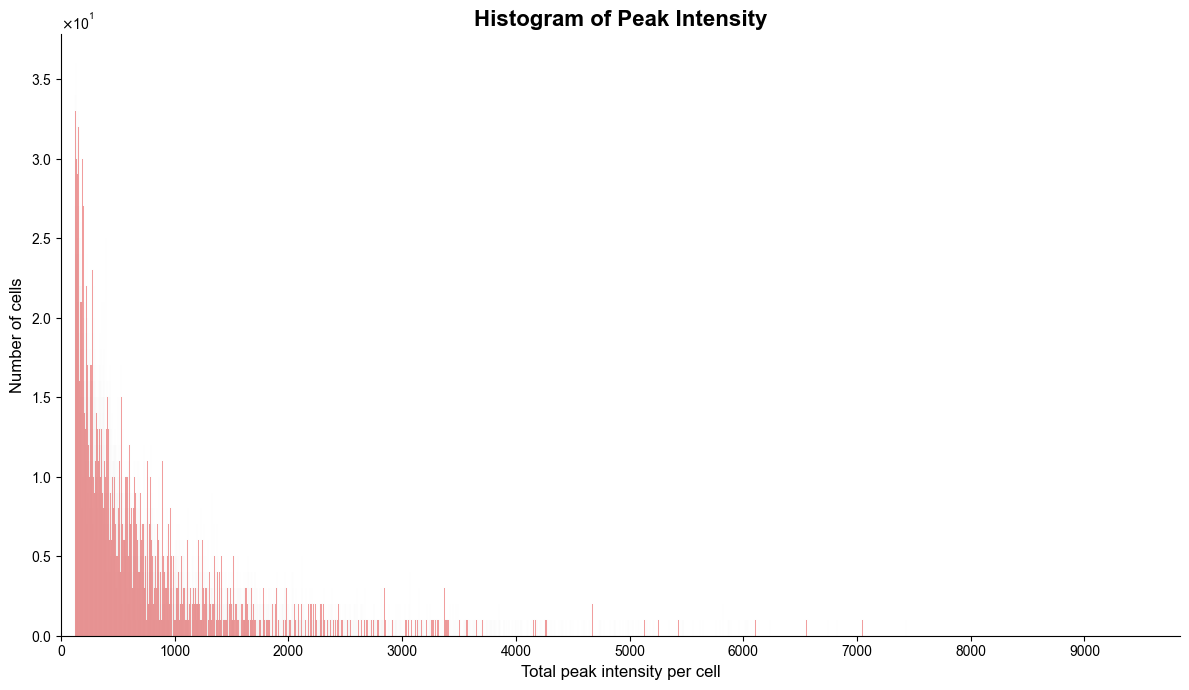

Histogram of the number of counts of each unique gene symbols:


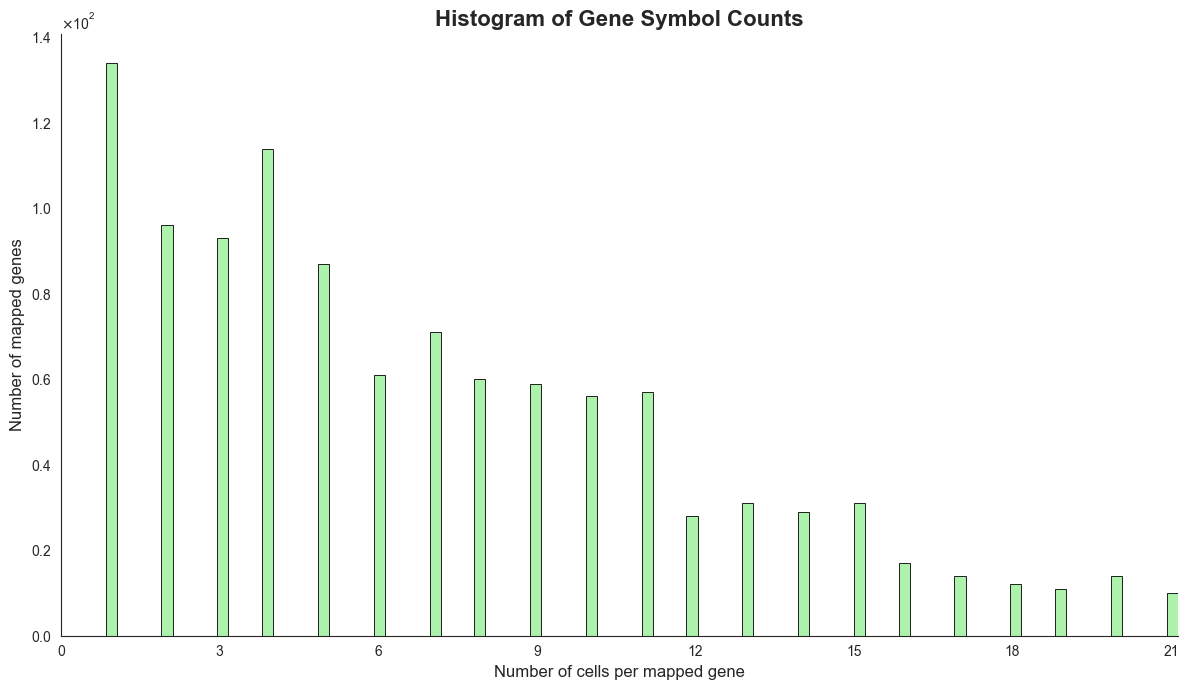

In [41]:
print("Preparing reads")
df_reads_multi = prep_multi_reads(
    df_reads,
    map_start=MAP_START,
    map_end=MAP_END,
    recomb_start=RECOMB_START,
    recomb_end=RECOMB_END,
    map_col=MAP_COL,
    recomb_col=RECOMB_COL
)

print("Corrected cells:")
df_cells = call_cells_multi(
    df_reads_multi, 
    df_barcode_library=df_barcode_library, 
    q_min=Q_MIN,
    map_col=MAP_COL,
    error_correct=ERROR_CORRECT,
    recomb_col=RECOMB_COL,
    recomb_filter_col=RECOMB_FILTER_COL,
    recomb_q_thresh=RECOMB_Q_THRESHOLD,
)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = extract_phenotype_minimal(
    phenotype_data=nuclei, nuclei_data=nuclei, wildcards=WILDCARDS
)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="one",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="any",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_cell_metric_histogram(df_cells, sort_by=SORT_CALLS)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells)
plt.show()

In [42]:
def plot_cells_vs_threshold(
    df_data, 
    df_sbs_info,
    barcodes=None,
    threshold_var="peak", 
    mapping_to="one",
    mapping_strategy="barcodes",
    data_type="reads",
    ax=None, 
    num_thresholds=None, 
    **kwargs
):
    """Plot the percentage of cells with valid barcodes against varying thresholds.

    Args:
        df_data (pandas.DataFrame):
            Either df_reads (individual reads) or df_cells (aggregated cell data).
        df_sbs_info (pandas.DataFrame):
            DataFrame with cell information including 'well', 'tile', 'cell' columns.
        barcodes (list or set of str, optional):
            Expected barcodes from the pool library design. Required if mapping_strategy='barcodes'.
        threshold_var (str, optional):
            Variable to apply varying thresholds to. For reads: 'peak', 'QC_min'. 
            For cells: 'peak_0', 'peak_1', 'barcode_count'. Defaults to 'peak'.
        mapping_to (str, optional):
            'one' = cells mapping to exactly 1 barcode, 'any' = cells mapping to ≥1 barcode.
            Defaults to 'one'.
        mapping_strategy (str, optional):
            'barcodes' = use barcode columns, 'gene symbols' = use gene_symbol columns.
            Defaults to 'barcodes'.
        data_type (str, optional):
            'reads' = df_data is df_reads, 'cells' = df_data is df_cells. Defaults to 'reads'.
        ax (matplotlib.axis, optional):
            Axis object to plot on. If None, creates new figure. Defaults to None.
        num_thresholds (int, optional):
            Number of threshold points to evaluate. Defaults to None.
        **kwargs:
            Keyword arguments passed to sns.lineplot()

    Returns:
        pandas.DataFrame: Summary table of thresholds and cell mapping percentages.
        matplotlib.figure.Figure: The figure object containing the plot.
    """
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.lines import Line2D
    
    # Create figure if no axis provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    else:
        fig = ax.figure
    
    # Process data based on type
    if data_type == "reads":
        # For df_reads: aggregate to cell level first, then apply thresholds
        if mapping_strategy == "barcodes" and barcodes is not None:
            df_data_marked = df_data.copy()
            df_data_marked["mapped"] = df_data_marked["barcode"].isin(barcodes)
        else:
            df_data_marked = df_data.copy()
            df_data_marked["mapped"] = True  # Assume all reads are valid for gene symbol strategy
        
        # Generate thresholds
        if df_data[threshold_var].max() < 100:
            thresholds = np.array(range(0, int(np.quantile(df_data[threshold_var], q=0.99) * 1000))) / 1000
        else:
            thresholds = list(range(0, int(np.quantile(df_data[threshold_var], q=0.99)), 10))
        
        if num_thresholds is not None:
            indices = np.linspace(0, len(thresholds) - 1, num_thresholds, dtype=int)
            thresholds = [thresholds[i] for i in indices]
        
        # Calculate metrics for each threshold
        cell_mapping_percentages = []
        mapped_cell_counts = []
        total_cell_counts = []
        
        for threshold in thresholds:
            # Filter reads by threshold
            df_thresh = df_data_marked.query(f"{threshold_var} > @threshold")
            
            if len(df_thresh) == 0:
                cell_mapping_percentages.append(0)
                mapped_cell_counts.append(0)
                total_cell_counts.append(0)
                continue
            
            # Aggregate to cell level
            if mapping_strategy == "barcodes":
                # Count mapped reads per cell
                cell_stats = df_thresh.groupby(["well", "tile", "cell"]).agg({
                    "mapped": "sum",
                    "barcode": "count"
                }).reset_index()
                cell_stats["barcode_count"] = cell_stats["mapped"]
            else:
                # For gene symbols, just count reads per cell
                cell_stats = df_thresh.groupby(["well", "tile", "cell"]).size().reset_index(name="barcode_count")
            
            # Merge with all cells to get total count
            all_cells = df_sbs_info[["well", "tile", "cell"]].merge(
                cell_stats, on=["well", "tile", "cell"], how="left"
            ).fillna(0)
            
            # Determine mapping based on criteria
            if mapping_to == "one":
                mapped_cells = (all_cells["barcode_count"] == 1).sum()
            else:  # "any"
                mapped_cells = (all_cells["barcode_count"] >= 1).sum()
            
            total_cells = len(all_cells)
            percentage = (mapped_cells / total_cells * 100) if total_cells > 0 else 0
            
            cell_mapping_percentages.append(percentage)
            mapped_cell_counts.append(mapped_cells)
            total_cell_counts.append(total_cells)
    
    else:  # data_type == "cells"
        # For df_cells: data is already at cell level
        
        # Determine threshold column and range
        if threshold_var in ["peak_0", "peak_1"]:
            thresh_data = df_data[threshold_var].fillna(0)
        elif threshold_var == "barcode_count":
            thresh_data = df_data[threshold_var].fillna(0)
        else:
            # Try to find the column in df_data
            if threshold_var in df_data.columns:
                thresh_data = df_data[threshold_var].fillna(0)
            else:
                raise ValueError(f"Column '{threshold_var}' not found in df_data")
        
        # Generate thresholds
        if thresh_data.max() < 100:
            thresholds = np.array(range(0, int(np.quantile(thresh_data, q=0.99) * 1000))) / 1000
        else:
            thresholds = list(range(0, int(np.quantile(thresh_data, q=0.99)), 1))
        
        if num_thresholds is not None:
            indices = np.linspace(0, len(thresholds) - 1, num_thresholds, dtype=int)
            thresholds = [thresholds[i] for i in indices]
        
        # Calculate metrics for each threshold
        cell_mapping_percentages = []
        mapped_cell_counts = []
        total_cell_counts = []
        
        for threshold in thresholds:
            # Filter cells by threshold
            df_thresh = df_data.query(f"{threshold_var} > @threshold")
            
            # Merge with all cells
            all_cells = df_sbs_info[["well", "tile", "cell"]].merge(
                df_thresh, on=["well", "tile", "cell"], how="left"
            )
            
            # Determine mapping based on strategy and criteria
            if mapping_strategy == "barcodes":
                if barcodes is not None:
                    all_cells["mapped_0"] = all_cells["cell_barcode_0"].isin(barcodes).astype(int)
                    all_cells["mapped_1"] = all_cells["cell_barcode_1"].isin(barcodes).astype(int)
                else:
                    all_cells["mapped_0"] = (~all_cells["cell_barcode_0"].isna()).astype(int)
                    all_cells["mapped_1"] = (~all_cells["cell_barcode_1"].isna()).astype(int)
            else:  # gene symbols
                all_cells["mapped_0"] = (~all_cells["gene_symbol_0"].isna()).astype(int)
                all_cells["mapped_1"] = (~all_cells["gene_symbol_1"].isna()).astype(int)
            
            all_cells["total_mapped"] = all_cells["mapped_0"] + all_cells["mapped_1"]
            
            # Apply mapping criteria
            if mapping_to == "one":
                mapped_cells = (all_cells["total_mapped"] == 1).sum()
            else:  # "any"
                mapped_cells = (all_cells["total_mapped"] >= 1).sum()
            
            total_cells = len(all_cells)
            percentage = (mapped_cells / total_cells * 100) if total_cells > 0 else 0
            
            cell_mapping_percentages.append(percentage)
            mapped_cell_counts.append(mapped_cells)
            total_cell_counts.append(total_cells)
    
    # Create summary DataFrame
    df_summary = pd.DataFrame({
        f"{threshold_var}_threshold": thresholds,
        "cell_mapping_percentage": cell_mapping_percentages,
        "mapped_cells": mapped_cell_counts,
        "total_cells": total_cell_counts,
    })
    
    # Plot main line (percentage)
    sns.lineplot(
        data=df_summary,
        x=f"{threshold_var}_threshold",
        y="cell_mapping_percentage",
        ax=ax,
        color="steelblue",
        linewidth=2,
        **kwargs,
    )
    
    # Secondary axis for absolute counts
    ax_right = ax.twinx()
    
    sns.lineplot(
        data=df_summary,
        x=f"{threshold_var}_threshold",
        y="mapped_cells",
        ax=ax_right,
        color="coral",
        linewidth=2,
        **kwargs,
    )
    
    # Labels and titles
    mapping_desc = f"Exactly 1 {mapping_strategy.rstrip('s')}" if mapping_to == "one" else f"≥1 {mapping_strategy.rstrip('s')}"
    
    ax.set_ylabel(f"Percentage of Cells with\n{mapping_desc}", fontsize=12, color='steelblue')
    ax.set_xlabel(f"{threshold_var.replace('_', ' ').title()} Threshold", fontsize=12)
    ax.set_title(f"Cell Mapping vs {threshold_var.title()} Threshold\n({data_type.title()} Data)", fontsize=14)
    ax_right.set_ylabel("Number of Mapped Cells", fontsize=12, color='coral')
    
    # Color the tick labels to match
    ax.tick_params(axis='y', labelcolor='steelblue')
    ax_right.tick_params(axis='y', labelcolor='coral')
    
    # Formatting
    ax.set_ylim(0, 100)  # Percentage scale
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    
    # Legend
    legend_elements = [
        Line2D([0], [0], color="steelblue", linewidth=2, label=f"Percentage: {mapping_desc}"),
        Line2D([0], [0], color="coral", linewidth=2, label="Absolute Count: Mapped cells"),
    ]
    
    ax.legend(handles=legend_elements, loc="upper left")
    
    # Grid and styling
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return df_summary, fig

(     peak_threshold  cell_mapping_percentage  mapped_cells  total_cells
 0                 0                27.735320          4355        15702
 1                10                27.735320          4355        15702
 2                20                27.735320          4355        15702
 3                30                27.735320          4355        15702
 4                40                27.735320          4355        15702
 ..              ...                      ...           ...          ...
 368            3680                 0.375748            59        15702
 369            3690                 0.369380            58        15702
 370            3700                 0.369380            58        15702
 371            3710                 0.369380            58        15702
 372            3720                 0.363011            57        15702
 
 [373 rows x 4 columns],
 <Figure size 1000x600 with 2 Axes>)

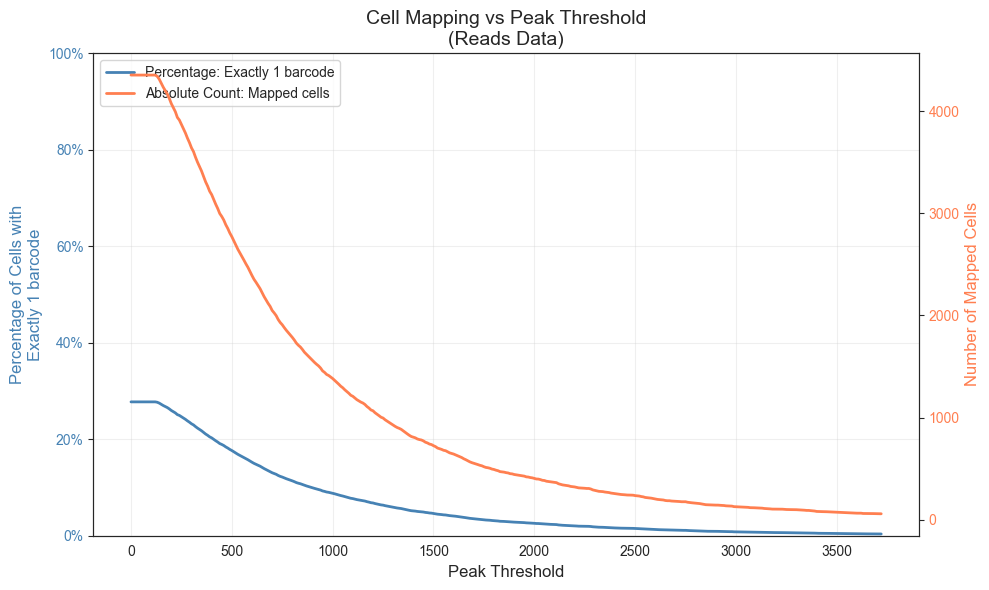

In [43]:
plot_cells_vs_threshold(
    df_reads, 
    df_sbs_info, 
    barcodes=barcodes,
    threshold_var="peak",
    mapping_to="one",
    mapping_strategy="barcodes",
    data_type="reads",
)

(      peak_0_threshold  cell_mapping_percentage  mapped_cells  total_cells
 0                    0                49.063814          7704        15702
 1                    1                49.063814          7704        15702
 2                    2                49.063814          7704        15702
 3                    3                49.063814          7704        15702
 4                    4                49.063814          7704        15702
 ...                ...                      ...           ...          ...
 3923              3923                 0.464909            73        15702
 3924              3924                 0.464909            73        15702
 3925              3925                 0.464909            73        15702
 3926              3926                 0.464909            73        15702
 3927              3927                 0.464909            73        15702
 
 [3928 rows x 4 columns],
 <Figure size 1000x600 with 2 Axes>)

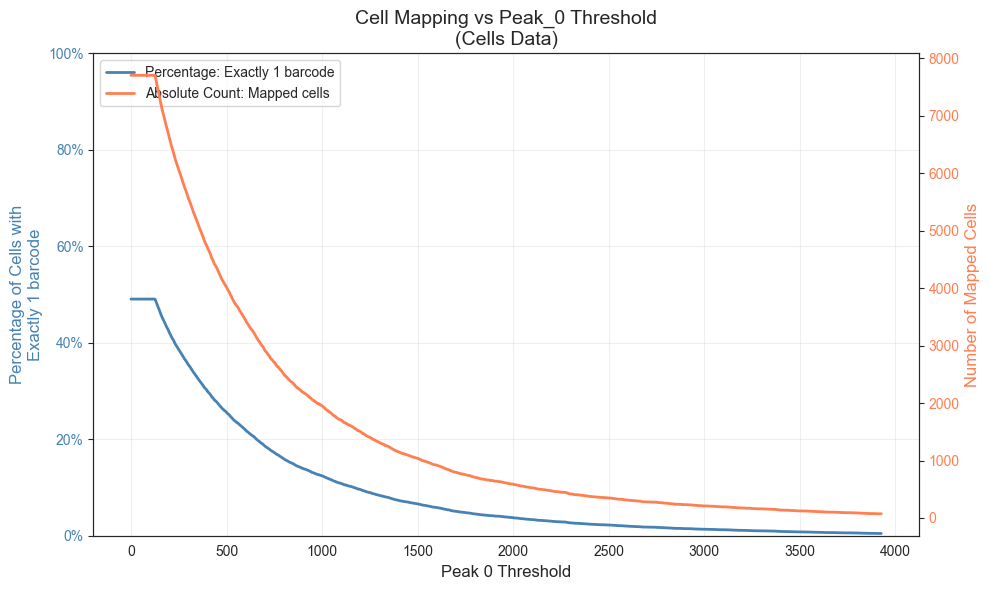

In [44]:
plot_cells_vs_threshold(
    df_cells, 
    df_sbs_info, 
    barcodes=barcodes,
    threshold_var="peak_0",
    mapping_to="one",
    mapping_strategy="barcodes",
    data_type="cells",
)

In [45]:
# save nuclei masks that do and do not have a mapped barcode
from tifffile import imwrite
import numpy as np

# Get cell IDs that are mapped vs unmapped
mapped_cell_ids = set(df_cells[df_cells['mapped'] == True]['cell'].values)
unmapped_cell_ids = set(df_cells[df_cells['mapped'] == False]['cell'].values)

# Create masks for nuclei
nuclei_mapped = np.where(np.isin(nuclei, list(mapped_cell_ids)), nuclei, 0)
nuclei_unmapped = np.where(np.isin(nuclei, list(unmapped_cell_ids)), nuclei, 0)

# Save the results
imwrite("nuclei_mapped.tiff", nuclei_mapped.astype(np.uint16))
imwrite("nuclei_unmapped.tiff", nuclei_unmapped.astype(np.uint16))

## Add sbs process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_sbs_paramsearch` will systematically explore combinations of parameters for segmentation accuracy. This is not yet implemented.

In [46]:
# Add sbs section
config["sbs"] = {
    "alignment_method": ALIGNMENT_METHOD,
    "channel_names": CHANNEL_NAMES,
    "upsample_factor": UPSAMPLE_FACTOR,
    "skip_cycles_indices": SKIP_CYCLES_INDICES,
    "manual_background_cycle_index": MANUAL_BACKGROUND_CYCLE_INDEX,
    "extra_channel_indices": EXTRA_CHANNEL_INDICES,
    "max_filter_width": MAX_FILTER_WIDTH,
    "spot_detection_method": SPOT_DETECTION_METHOD,
    "dapi_cycle": DAPI_CYCLE,
    "cyto_cycle": CYTO_CYCLE,
    "cyto_cycle_index": CYTO_CYCLE_INDEX,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "gpu": GPU,
    "segment_cells": SEGMENT_CELLS,
    "df_barcode_library_fp": DF_BARCODE_LIBRARY_FP,
    "sequencing_order": SEQUENCING_ORDER,
    "threshold_peaks": THRESHOLD_READS,
    "call_reads_method": CALL_READS_METHOD,
    "bases": BASES,
    "q_min": Q_MIN,
    "recomb_start": RECOMB_START,
    "recomb_end": RECOMB_END,
    "map_start": MAP_START,
    "map_end": MAP_END,
    "map_col": MAP_COL,
    "recomb_col": RECOMB_COL,
    "recomb_filter_col": RECOMB_FILTER_COL,
    "error_correct": ERROR_CORRECT,
    "recomb_q_thresh": RECOMB_Q_THRESHOLD,
    "barcode_info_cols": BARCODE_INFO_COLS,
    "max_distance": MAX_DISTANCE,
    "sort_calls": SORT_CALLS,
    "mode": None,
}

# Add spot detection method specific parameters
if SPOT_DETECTION_METHOD == "standard":
    config["sbs"].update({
        "peak_width": PEAK_WIDTH,
    })
elif SPOT_DETECTION_METHOD == "spotiflow":
    config["sbs"].update({
        "spotiflow_cycle_index": SPOTIFLOW_CYCLE_INDEX,
        "spotiflow_model": SPOTIFLOW_MODEL,
        "spotiflow_threshold": SPOTIFLOW_THRESHOLD,
        "spotiflow_min_distance": SPOTIFLOW_MIN_DISTANCE,
    })

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["sbs"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["sbs"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["sbs"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })
elif SEGMENTATION_METHOD == "watershed":
    config["sbs"].update({
        "threshold_dapi": THRESHOLD_DAPI,
        "nucleus_area_min": NUCLEUS_AREA[0],
        "nucleus_area_max": NUCLEUS_AREA[1],
        "threshold_cell": THRESHOLD_CELL,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)